# Table of contents

1. [**Data cleaning**](#data_cleaning)\
    1.1. [Overview](#overview)\
    1.2. [Inspection ID](#inspection_ID)\
    1.3. [DBA Name and AKA Name](#dba_aka_name)\
    1.4. [License #](#license)\
    1.5. [Risk](#risk)\
    1.6. [Results](#results)\
    1.7. [Violations](#violations)\
    1.8. [Address](#address)\
    1.9. [City & State & Zip](#city_state_zip) \
    1.10. [Latitude & Longitude & Location](#latitude_longitude_location)\
    1.11. [Inspection Date](#inspection_date)\
    1.12. [Facility Type](#facility_type)\
    1.13. [Inspection Type](#inspection_type)
    

2. [**Exploratory Data Analysis**](#data_exploration)\
    2.1. [Overview](#overview2)\
    2.2. [Analysis by time](#analysis_by_time)\
    2.3. [Analysis by Facility Type](#analysis_by_facility_type)\
    2.4. [Analysis by Inspection Type](#analysis_by_inspection_type)\
    2.5. [Analysis by Community Area](#analysis_by_community_area)
    
    
3. [**Chicago Crime Records and Life Expectancy**](#Crime)\
    3.1. [Chicago Life Expectancy](#life)\
    3.2. [Chicago Crime Records](#crime)


4. [**Further Analysis with Yelp**](#Yelp)\
    4.1. [Data Cleaning](#Yelp_data_cleaning)\
    4.2. [Similarity Join with Chicago Food Inspection](#sim_join)

In [99]:
import pandas as pd
import numpy as np
import pickle
import json

# clean data
from datetime import datetime
import textdistance
import xlrd # library to read excel files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium # map rendering library
from folium import *
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


from shapely.geometry import Point
from shapely.geometry import MultiPolygon, Polygon
import geopandas as gpd

from IPython.display import Image
from PIL import Image as Im

# 1. Data cleaning <a name="data_cleaning"></a>

In [2]:
CHICAGO_PATH = 'data_raw/food-inspections.csv'
CHICAGO_PICKLE_PATH = "data_cleaned/chicago.pkl"
COMMUNITY_PATH = 'data_raw/CommAreas.csv'

### 1.1 Overview <a name="overview"></a>

**Load Data**

In [4]:
chicago_raw = pd.read_csv(CHICAGO_PATH)
chicago_raw.head(3)

Inspection ID                       DBA Name                      AKA Name  \
0        2345318                         SUBWAY                        SUBWAY   
1        2345334  LA MICHOACANA  ICE CREAM SHOP  LA MICHOACANA ICE CREAM SHOP   
2        2345339                 THE CREPE SHOP                THE CREPE SHOP   

   License # Facility Type           Risk                     Address  \
0  2529116.0    Restaurant  Risk 1 (High)    2620 N NARRAGANSETT AVE    
1  2698396.0    Restaurant  Risk 1 (High)  3591-3597 N MILWAUKEE AVE    
2  2699005.0    Restaurant  Risk 1 (High)            2934 N BROADWAY    

      City State      Zip  ...             Results  \
0  CHICAGO    IL  60639.0  ...  Pass w/ Conditions   
1  CHICAGO    IL  60641.0  ...  Pass w/ Conditions   
2  CHICAGO    IL  60657.0  ...                Fail   

                                          Violations   Latitude  Longitude  \
0  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.927995 -87.785752   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.946140 -87.735183   
2  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.935930 -87.644407   

                                            Location  \
0  {'longitude': '41.92799528871574', 'latitude':...   
1  {'longitude': '41.94614005344282', 'latitude':...   
2  {'longitude': '41.93592957402078', 'latitude':...   

   Historical Wards 2003-2015 Zip Codes  Community Areas  Census Tracts  Wards  
0                         NaN       NaN              NaN            NaN    NaN  
1                         NaN       NaN              NaN            NaN    NaN  
2                         NaN       NaN              NaN            NaN    NaN  

[3 rows x 22 columns]

In [5]:
chicago_raw.describe()

Inspection ID     License #            Zip       Latitude  \
count   1.957360e+05  1.957190e+05  195686.000000  195051.000000   
mean    1.444443e+06  1.598641e+06   60628.730231      41.881225   
std     6.338334e+05  8.961408e+05     122.256930       0.080851   
min     4.424700e+04  0.000000e+00   10014.000000      41.644670   
25%     1.150517e+06  1.224021e+06   60614.000000      41.834761   
50%     1.490758e+06  1.979463e+06   60625.000000      41.891897   
75%     1.995427e+06  2.234235e+06   60643.000000      41.939814   
max     2.345339e+06  9.999999e+06   60827.000000      42.021064   

           Longitude  Historical Wards 2003-2015  Zip Codes  Community Areas  \
count  195051.000000                         0.0        0.0              0.0   
mean      -87.676827                         NaN        NaN              NaN   
std         0.058968                         NaN        NaN              NaN   
min       -87.914428                         NaN        NaN              NaN   
25%       -87.707788                         NaN        NaN              NaN   
50%       -87.666812                         NaN        NaN              NaN   
75%       -87.634955                         NaN        NaN              NaN   
max       -87.525094                         NaN        NaN              NaN   

       Census Tracts  Wards  
count            0.0    0.0  
mean             NaN    NaN  
std              NaN    NaN  
min              NaN    NaN  
25%              NaN    NaN  
50%              NaN    NaN  
75%              NaN    NaN  
max              NaN    NaN

**Remove the following columns which contain only NaN values**  
'Historical Wards 2003-2015',  
'Zip Codes',  
'Community Areas',   
'Census Tracts',   
'Wards'  

In [6]:
columns_drop = ['Historical Wards 2003-2015', 'Zip Codes',
               'Community Areas', 'Census Tracts', 'Wards']
chicago_raw = chicago_raw.drop(columns = columns_drop)

**Remove duplicated rows**

In [6]:
print('The number of duplicated rows: ', chicago_raw.duplicated().sum())

The number of duplicated rows:  212


In [7]:
print("The number of rows before dropping duplicated rows: %d" %(chicago_raw.shape[0]))
chicago_raw = chicago_raw.drop_duplicates()
print("The number of rows after dropping duplicated rows: %d" %(chicago_raw.shape[0]))

The number of rows before dropping duplicated rows: 195736
The number of rows after dropping duplicated rows: 195524


### 1.2. Inspection ID  <a name="inspection_ID"></a>

Check the number of NaN in Inspection column

In [8]:
print('The number of NaN in Inspection column: ', chicago_raw['Inspection ID'].isna().sum())

The number of NaN in Inspection column:  0


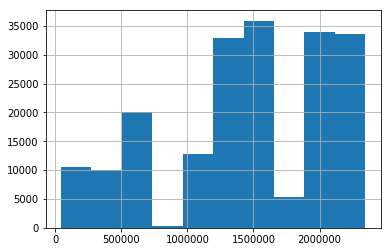

In [9]:
chicago_raw['Inspection ID'].hist()

### 1.3. DBA name and AKA name <a name="dba_aka_name"></a>

In [10]:
chicago_raw['DBA Name'] = chicago_raw['DBA Name'].str.lower()
chicago_raw['AKA Name'] = chicago_raw['AKA Name'].str.lower()

Check the number of NaN in `DBA Name` column and `AKA Name` column

In [11]:
chicago_raw[['DBA Name', 'AKA Name']].isnull().sum()

DBA Name       0
AKA Name    2455
dtype: int64

In this chicago_raw dataset the DBA Name always exists for each row,
so we can fill the NaN `AKA Name` with the corresponding `DBA name`

In [12]:
chicago_raw['AKA Name'].fillna(chicago_raw['DBA Name'], inplace=True)

In [13]:
chicago_raw[['DBA Name', 'AKA Name']].isnull().sum()

DBA Name    0
AKA Name    0
dtype: int64

We can observe that all the NaN `AKA Name` are filled with the corresponding `DBA Name`

### 1.4. License # <a name="license"></a>

In [14]:
print('The number of NaN in Licence # column', chicago_raw['License #'].isna().sum())

The number of NaN in Licence # column 17


In [15]:
chicago_raw['License #'].min()

0.0

In [16]:
chicago_raw[chicago_raw['License #'] == 0.0].head(3)

Inspection ID                     DBA Name                     AKA Name  \
1089        2315561  dore early childhood center  dore early childhood center   
1391        2313166                   el costeno                   el costeno   
1467        2313036        taft freshman academy        taft freshman academy   

      License #         Facility Type           Risk  \
1089        0.0                School  Risk 1 (High)   
1391        0.0  Mobile Food Preparer  Risk 1 (High)   
1467        0.0                School  Risk 1 (High)   

                        Address     City State      Zip  \
1089         6108 S Natoma AVE   CHICAGO    IL  60638.0   
1391             235 W 87TH ST   CHICAGO    IL  60620.0   
1467  4071 N OAK PARK AVE BSMT   CHICAGO    IL  60634.0   

              Inspection Date Inspection Type Results  \
1089  2019-10-09T00:00:00.000         Canvass    Pass   
1391  2019-10-01T00:00:00.000       Complaint    Fail   
1467  2019-09-27T00:00:00.000         Canvass    Pass   

                                             Violations   Latitude  Longitude  \
1089                                                NaN  41.780927 -87.787640   
1391  1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...  41.735933 -87.629878   
1467  52. SEWAGE & WASTE WATER PROPERLY DISPOSED - C...  41.954631 -87.796455   

                                               Location  
1089  {'longitude': '41.78092716332793', 'latitude':...  
1391  {'longitude': '41.73593344061027', 'latitude':...  
1467  {'longitude': '41.95463092640079', 'latitude':...

**Observe**  
License number is a unique number assigned to the establishment for the purposes of licensing by the Department of Business Affairs and Consumer Protection. We observe that the License number 0.0 corresponds to several different establishments, so 0.0 is an invalid license number.  
We fill the NaN license number with 0.0. And in the later analysis, we treat the number 0.0 as an invalid license number.

In [17]:
chicago_raw['License #'].fillna(0.0, inplace=True)

### 1.5. Risk

Each establishment is categorized as to its risk of adversely affecting the public’s health, with **1 being the highest** and **3 the lowest**. The frequency of inspection is tied to this risk, **with risk 1 establishments inspected most frequently and risk 3 least frequently.** First, we check the number of inspections for ecah risk level.

In [18]:
chicago_raw['Risk'] = chicago_raw['Risk'].str.lower()

In [19]:
chicago_raw['Risk'].unique()

array(['risk 1 (high)', 'risk 3 (low)', 'risk 2 (medium)', nan, 'all'],
      dtype=object)

There are five types in `Risk` column: **risk 1 (high)**, **risk 2 (medium)**, **risk 3 (low)**, **all** and **nan**, we check the number of records for each risk type.

In [20]:
chicago_raw['Risk'].value_counts()

risk 1 (high)      140164
risk 2 (medium)     38173
risk 3 (low)        17085
all                    29
Name: Risk, dtype: int64

In [21]:
print("The number of NaN in Risk Column: ", chicago_raw['Risk'].isnull().sum())

The number of NaN in Risk Column:  73


We can observe that **risk 1 (high)** > **risk 2 (medium)** > **risk 3 (low)** > **all**， this is coincident with the theory that risk 1 is inpected most frequently.  
We fill the NaN with **unknown**

In [22]:
chicago_raw['Risk'].fillna('unknown', inplace=True)

### 1.6. Results <a name="results"></a>

In [23]:
chicago_raw['Results'] = chicago_raw['Results'].str.lower()

In [24]:
print("The number of NaN in Results column: ", chicago_raw['Results'].isnull().sum())

The number of NaN in Results column:  0


In [25]:
chicago_raw['Results'].unique()

array(['pass w/ conditions', 'fail', 'pass', 'out of business',
       'no entry', 'not ready', 'business not located'], dtype=object)

An inspection can pass, pass with conditions or fail.   
- **pass**: Establishments receiving a pass were found to have no critical or serious violations.  
- **pass w/ conditions**: Establishments receiving a pass with conditions were found to have critical or serious violations, but these were corrected during the inspection.   
- **fail**: Establishments receiving a fail were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended.  
- **out of business/business not located**: Establishments found to be out of business or not located are indicated as such.

In [26]:
chicago_raw['Results'].value_counts()

pass                    105674
fail                     37825
pass w/ conditions       27035
out of business          16824
no entry                  6222
not ready                 1876
business not located        68
Name: Results, dtype: int64

We rename the `business not located` as `out of business` since they both mean the establishment’s licensed is suspended.

In [27]:
chicago_raw.loc[chicago_raw['Results'] == 'business not located', 'Results'] = 'out of business'

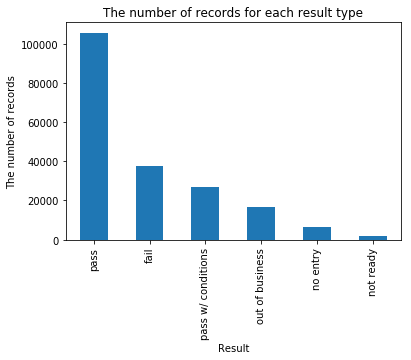

In [28]:
chicago_raw['Results'].value_counts().plot.bar()
plt.xlabel('Result')
plt.ylabel('The number of records')
plt.title('The number of records for each result type')
plt.show()

### 1.7. Violations <a name="violations"></a>

In [29]:
chicago_raw['Violations'] = chicago_raw['Violations'].str.lower()

It is normal for **Violations** column to have NaN value which means that there is no violation during the specific inspection.  
We extract the violation number for later analysis.

In [30]:
def extract_violation_number(violations):
    if pd.isnull(violations):
        return []
    violation_list = violations.split('|')
    return [violation.split('. ')[0].strip() for violation in violation_list]
    
chicago_raw['Violations Number'] = chicago_raw.Violations.apply(extract_violation_number)

In [31]:
chicago_raw.head(3)

Inspection ID                       DBA Name                      AKA Name  \
0        2345318                         subway                        subway   
1        2345334  la michoacana  ice cream shop  la michoacana ice cream shop   
2        2345339                 the crepe shop                the crepe shop   

   License # Facility Type           Risk                     Address  \
0  2529116.0    Restaurant  risk 1 (high)    2620 N NARRAGANSETT AVE    
1  2698396.0    Restaurant  risk 1 (high)  3591-3597 N MILWAUKEE AVE    
2  2699005.0    Restaurant  risk 1 (high)            2934 N BROADWAY    

      City State      Zip          Inspection Date        Inspection Type  \
0  CHICAGO    IL  60639.0  2019-11-08T00:00:00.000  Canvass Re-Inspection   
1  CHICAGO    IL  60641.0  2019-11-08T00:00:00.000                License   
2  CHICAGO    IL  60657.0  2019-11-08T00:00:00.000                License   

              Results                                         Violations  \
0  pass w/ conditions  3. management, food employee and conditional e...   
1  pass w/ conditions  3. management, food employee and conditional e...   
2                fail  10. adequate handwashing sinks properly suppli...   

    Latitude  Longitude                                           Location  \
0  41.927995 -87.785752  {'longitude': '41.92799528871574', 'latitude':...   
1  41.946140 -87.735183  {'longitude': '41.94614005344282', 'latitude':...   
2  41.935930 -87.644407  {'longitude': '41.93592957402078', 'latitude':...   

          Violations Number  
0                [3, 5, 58]  
1            [3, 5, 51, 57]  
2  [10, 39, 48, 51, 53, 55]

### 1.8. Address <a name="address"></a>

In [32]:
chicago_raw['Address'] = chicago_raw['Address'].str.lower()
print('The number of NaN in Address column: ', chicago_raw['Address'].isnull().sum())

The number of NaN in Address column:  0


### 1.9. City & State & Zip <a name="city_state_zip"></a>

#### Zip

use the `Latitude` and `Longitude` information to fill the NaN `Zip` field  

In [33]:
print("The number of NaN in Zip column: ", chicago_raw['Zip'].isnull().sum())
print("The number of NaN in Zip column while Latitude and Longitude are not NaN: ", (chicago_raw['Zip'].isnull() & ~chicago_raw['Latitude'].isnull() & ~chicago_raw['Longitude'].isnull()).sum())

The number of NaN in Zip column:  50
The number of NaN in Zip column while Latitude and Longitude are not NaN:  47


we use **geopy.geocoders** (https://geopy.readthedocs.io/en/stable/#module-geopy.geocoders) to generate zip code from latitude and longitude

In [34]:
geolocator = Nominatim(user_agent="MagicADA",timeout=10)

In [35]:
index = chicago_raw['Zip'].isnull() & ~chicago_raw['Latitude'].isnull() & ~chicago_raw['Longitude'].isnull()
chicago_raw.loc[index, 'Zip'] = chicago_raw.loc[index, ['Latitude', 'Longitude']]\
                               .apply(lambda x: float(geolocator\
                               .reverse(str(x.Latitude)+", "+str(x.Longitude)).raw['address']['postcode']), axis=1)

In [36]:
print("The number of NaN in Zip column aftering filling: ", chicago_raw['Zip'].isnull().sum())

The number of NaN in Zip column aftering filling:  3


Download **Chicago official zip code** from the Chicago official website https://www.chicago.gov/city/en/depts/doit/dataset/boundaries_-_zipcodes.html

In [37]:
zip_codes = pd.read_csv('data_raw/Zip_Codes.csv')
chicago_official_zip = np.sort(zip_codes.ZIP.unique())
chicago_official_zip

array([60601, 60602, 60603, 60604, 60605, 60606, 60607, 60608, 60609,
       60610, 60611, 60612, 60613, 60614, 60615, 60616, 60617, 60618,
       60619, 60620, 60621, 60622, 60623, 60624, 60625, 60626, 60628,
       60629, 60630, 60631, 60632, 60633, 60634, 60636, 60637, 60638,
       60639, 60640, 60641, 60642, 60643, 60644, 60645, 60646, 60647,
       60649, 60651, 60652, 60653, 60654, 60655, 60656, 60657, 60659,
       60660, 60661, 60666, 60707, 60827])

Extract all the zip code in our Chicago food inspection dataset, we observe that there are some zip codes not belong to Chicago

In [38]:
all_zip_code_in_dataset = np.sort(chicago_raw['Zip'].unique())
all_zip_code_in_dataset

array([10014., 46319., 53061., 60007., 60015., 60018., 60022., 60035.,
       60044., 60047., 60076., 60077., 60083., 60091., 60102., 60107.,
       60108., 60126., 60148., 60153., 60155., 60176., 60189., 60193.,
       60201., 60202., 60302., 60402., 60406., 60409., 60411., 60423.,
       60429., 60438., 60440., 60453., 60455., 60458., 60461., 60464.,
       60477., 60478., 60482., 60501., 60540., 60559., 60585., 60601.,
       60602., 60603., 60604., 60605., 60606., 60607., 60608., 60609.,
       60610., 60611., 60612., 60613., 60614., 60615., 60616., 60617.,
       60618., 60619., 60620., 60621., 60622., 60623., 60624., 60625.,
       60626., 60627., 60628., 60629., 60630., 60631., 60632., 60633.,
       60634., 60636., 60637., 60638., 60639., 60640., 60641., 60642.,
       60643., 60644., 60645., 60646., 60647., 60649., 60651., 60652.,
       60653., 60654., 60655., 60656., 60657., 60659., 60660., 60661.,
       60666., 60706., 60707., 60714., 60803., 60804., 60805., 60827.,
      

In [39]:
print("The number of rows with Chicago offical zip code: ", chicago_raw[chicago_raw['Zip'].isin(chicago_official_zip)].shape[0])
print("The number of rows with zip codes out of Chicago: ", chicago_raw[~chicago_raw['Zip'].isin(chicago_official_zip)].shape[0])

The number of rows with Chicago offical zip code:  195343
The number of rows with zip codes out of Chicago:  181


The food inspection dataset is derived from inspections of restaurants and other food establishments in **Chicago** from January 1, 2010 to the present. So it makes sense that most of the rows have Chicago zip codes. For the rows with zip codes out of Chicago, we consider them as invalid and remove them.

In [40]:
chicago_raw = chicago_raw.loc[chicago_raw['Zip'].isin(chicago_official_zip)]
print("The size of Chicago inspection food dataset after filtering the records not belong to Chicago: ", chicago_raw.shape)

The size of Chicago inspection food dataset after filtering the records not belong to Chicago:  (195343, 18)


In [41]:
chicago_raw.Zip = chicago_raw.Zip.astype(int)

####  State

In [42]:
print('The number of NaN in State column: ', chicago_raw['State'].isnull().sum())
chicago_raw['State'].unique()

The number of NaN in State column:  42


array(['IL', nan], dtype=object)

State contains either **IL** or **NaN**. Since we have filtered the records with the zip codes not in Chicago, we can simply assume that NaN state is also **IL**

#### City

In [43]:
chicago_raw['City'] = chicago_raw['City'].str.lower()
chicago_raw['City'].unique()

array(['chicago', nan, 'cchicago', 'chicago.', 'chestnut street',
       'chicagochicago', 'chicagohicago', '312chicago', 'bedford park',
       'chcicago', 'charles a hayes', 'chchicago', 'chicagoi', 'inactive',
       'burnham', 'alsip'], dtype=object)

Apart from the typo problem of **Chicago**, there still several cities whose name are not **Chicago**.  

We check these cities (**chestnut street**, **bedford park**, **charles a hayes**, **inactive**, **burnham**, **alsip**) manually using Google map to see whether they belong to **Chicago** or not.  
Finally we find **burnham** and **alsip** are not belong to `Chicago`, they are neigborhoods of Chicago. We remove them from dataset.

In [44]:
chicago_raw[(chicago_raw['City']=='alsip')|(chicago_raw['City']=='burnham')]

Inspection ID      DBA Name      AKA Name  License # Facility Type  \
154069         679868  asc catering  asc catering  2148006.0           NaN   
158158         537834       wendy's       wendy's        0.0           NaN   

                   Risk              Address     City State    Zip  \
154069    risk 1 (high)    13946 s chippewa   burnham    IL  60633   
158158  risk 2 (medium)  11110 s cicero ave     alsip    IL  60655   

                Inspection Date Inspection Type          Results Violations  \
154069  2012-04-12T00:00:00.000         License             pass        NaN   
158158  2012-01-19T00:00:00.000       Complaint  out of business        NaN   

         Latitude  Longitude  \
154069        NaN        NaN   
158158  41.690487 -87.739869   

                                                 Location Violations Number  
154069                                                NaN                []  
158158  {'longitude': '41.69048672474855', 'latitude':...                []

In [45]:
chicago_raw = chicago_raw.loc[~chicago_raw['City'].isin(['burnham', 'alsip'])]
print("The size of Chicago inspection food dataset after filtering the cities not belong to Chicago: ", chicago_raw.shape)

The size of Chicago inspection food dataset after filtering the cities not belong to Chicago:  (195341, 18)


In [46]:
print('The number of NaN City: ', chicago_raw['City'].isnull().sum())

The number of NaN City:  135


Since we have filtered the records with the zip codes not in chicago, we can simply assume that NaN City is also **Chicago**.

Now we have filtered all the inspection records not belonging to Chicago and the remaining inspection records have the same **City** and **State** (Chicago and IL), we can remove these two columns.

In [47]:
chicago_raw.drop(columns=['City', 'State'], inplace=True)

### 1.10. Latitude & Longitude & Location <a name="latitude_longitude_location"></a>

**Fill NaN Latitude and NaN Longitude**

In [48]:
print('The number of NaN latitude: ', chicago_raw['Latitude'].isnull().sum())
print('The number of NaN longitude: ', chicago_raw['Longitude'].isnull().sum())
print('The number of NaN location: ', chicago_raw['Location'].isnull().sum())
print('The number of latitude, longtitude and location are NaN together: ', chicago_raw[['Latitude','Longitude', 'Location']].isnull().all(axis=1).sum())

The number of NaN latitude:  512
The number of NaN longitude:  512
The number of NaN location:  512
The number of latitude, longtitude and location are NaN together:  512


We observe that latitude, longitude and location always become NaN together, and **Location** column is duplicate with **Latitude** and **Longitude**, so we drop the **Location** column.

In [49]:
chicago_raw.drop(columns=['Location'], inplace=True)

Then, we use `Zip code` to calculate the `latitude`, `longitude`

In [50]:
chicago_raw.loc[chicago_raw['Latitude'].isnull(), 'Latitude'] = \
    chicago_raw.loc[chicago_raw['Latitude'].isnull(), ['Zip']].apply(lambda x: geolocator.geocode("Chicago, Illinois, " + str(x.Zip)).raw['lat'], axis=1)
chicago_raw.loc[chicago_raw['Longitude'].isnull(), 'Longitude'] = \
    chicago_raw.loc[chicago_raw['Longitude'].isnull(), ['Zip']].apply(lambda x: geolocator.geocode("Chicago, Illinois, " + str(x.Zip)).raw['lon'],axis=1)

In [51]:
print('The number of NaN latitude after using zip code the generate latitude: ', chicago_raw['Latitude'].isnull().sum())
print('The number of NaN longitude after using zip code the generate longtitude: ', chicago_raw['Longitude'].isnull().sum())

The number of NaN latitude after using zip code the generate latitude:  0
The number of NaN longitude after using zip code the generate longtitude:  0


In [52]:
chicago_raw.Latitude = chicago_raw.Latitude.astype(float)
chicago_raw.Longitude = chicago_raw.Longitude.astype(float)

**Add Community column**

We download the Chicago community information from the Chicago official website https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6, and add a new column `Community` to Chicago food inspection dataset for further analysis.

In [74]:
community_info = pd.read_csv(COMMUNITY_PATH)
community_info.head(3)

the_geom  PERIMETER  AREA  \
0  MULTIPOLYGON (((-87.60914087617894 41.84469250...          0     0   
1  MULTIPOLYGON (((-87.59215283879394 41.81692934...          0     0   
2  MULTIPOLYGON (((-87.62879823733725 41.80189303...          0     0   

   COMAREA_  COMAREA_ID  AREA_NUMBE    COMMUNITY  AREA_NUM_1    SHAPE_AREA  \
0         0           0          35      DOUGLAS          35  4.600462e+07   
1         0           0          36      OAKLAND          36  1.691396e+07   
2         0           0          37  FULLER PARK          37  1.991670e+07   

      SHAPE_LEN  
0  31027.054510  
1  19565.506153  
2  25339.089750

In [54]:
def find_community(row, community_dict):
    '''
    Find the community according to Latitude and Longitude
    
    Args: 
    row(pd.Series): a row of a dataset
    community_dict(dict): a dictionary where the key is the community name and the value is a shapely.polygon object 
    
    Return:
    the community name if the location corresponding this row falls in any community's polygon
    otherwise np.nan
    '''
    x, y = row['Longitude'], row['Latitude']
    point = Point(x, y)
    
    for community in community_dict:
        polygon = community_dict[community]
        if polygon.contains(point):
            return community
    
    return np.nan

We construct the dictionary where the key is each community of Chicago and the value is the corresponding shapely.polygon object on the map. \
Hence, we can find the corresponding community of each restaurant if its coordinate falls in any legal community in Chicago. 

In [55]:
community_dict = dict()
for i in range(len(community_info)):
    XY = []
    for coor in community_info['the_geom'].loc[i][13:].replace('(', '').replace(')', '').split(', '):
        x, y = coor.split(' ')
        XY.append( (float(x), float(y)) )
    community_dict[community_info['COMMUNITY'].loc[i]] = Polygon(XY)

chicago_raw['Community'] = chicago_raw.apply(lambda x: find_community(x, community_dict), axis = 1)

In [56]:
chicago_raw.head(3)

Inspection ID                       DBA Name                      AKA Name  \
0        2345318                         subway                        subway   
1        2345334  la michoacana  ice cream shop  la michoacana ice cream shop   
2        2345339                 the crepe shop                the crepe shop   

   License # Facility Type           Risk                     Address    Zip  \
0  2529116.0    Restaurant  risk 1 (high)    2620 n narragansett ave   60639   
1  2698396.0    Restaurant  risk 1 (high)  3591-3597 n milwaukee ave   60641   
2  2699005.0    Restaurant  risk 1 (high)            2934 n broadway   60657   

           Inspection Date        Inspection Type             Results  \
0  2019-11-08T00:00:00.000  Canvass Re-Inspection  pass w/ conditions   
1  2019-11-08T00:00:00.000                License  pass w/ conditions   
2  2019-11-08T00:00:00.000                License                fail   

                                          Violations   Latitude  Longitude  \
0  3. management, food employee and conditional e...  41.927995 -87.785752   
1  3. management, food employee and conditional e...  41.946140 -87.735183   
2  10. adequate handwashing sinks properly suppli...  41.935930 -87.644407   

          Violations Number       Community  
0                [3, 5, 58]  BELMONT CRAGIN  
1            [3, 5, 51, 57]     IRVING PARK  
2  [10, 39, 48, 51, 53, 55]       LAKE VIEW

### 1.11. Inspection Date<a name="inspection_date"></a>

In [57]:
print('The number of NaN in inspection date column: ', chicago_raw['Inspection Date'].isnull().sum())

The number of NaN in inspection date column:  0


In [58]:
# Change the inspection date from str to DateTime
chicago_raw['Inspection Date'] = chicago_raw['Inspection Date'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))

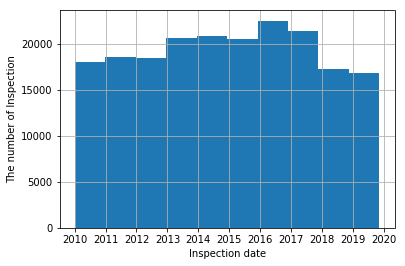

In [59]:
plt.hist(chicago_raw['Inspection Date'])
plt.xlabel("Inspection date")
plt.ylabel("The number of Inspection")
plt.grid()
plt.show()

The City of Chicago has adopted a new food code rules to better ensure food safety according to this website https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/understand_healthcoderequirementsforfoodestablishments.html. For all inspections completed after July 1, 2018 the Chicago Department of Public Health uses the new rules. So we add a new column `Rule Version` to indicate whether the inspection use the rules before or after the change of rules.

In [60]:
chicago_raw.loc[chicago_raw['Inspection Date'] < datetime(2018, 7, 1), 'Rule Version'] = 'old'
chicago_raw.loc[chicago_raw['Inspection Date'] > datetime(2018, 7, 1), 'Rule Version'] = 'new'

### 1.12. Facility Type <a name="facility_type"></a>

In [61]:
chicago_raw['Facility Type'] = chicago_raw['Facility Type'].str.lower()
print("The number of NaN in the facility type column is %d" % (chicago_raw['Facility Type'].isnull().sum()))
print("The number of different facility types is %d" % (chicago_raw['Facility Type'].nunique()))

The number of NaN in the facility type column is 4772
The number of different facility types is 437


In [62]:
chicago_raw['Facility Type'].fillna('other', inplace=True)
print("The number of [other] after fill the NaN with [other] %d " % \
      chicago_raw[chicago_raw['Facility Type'] == 'other'].shape[0])

The number of [other] after fill the NaN with [other] 4782 


Print the facility Types to have a taste about how to cluster them.

In [64]:
chicago_raw['Facility Type'].unique()[-20:]

array(['(gas station)', 'rooftop patio', 'coffee vending machine',
       'drug store/w/ food', 'commiasary', 'grocery/liquor',
       'ice cream parlor', 'produce stand', "farmer's market",
       'linited business', 'produce vendor', 'soup kitchen',
       'hooka lounge', 'candy maker', 'religious', 'tavern/liquor',
       'candy', 'incubator', 'wholesale bakery', "kids cafe'"],
      dtype=object)

In [65]:
facility_type_percent = pd.DataFrame({'count': chicago_raw['Facility Type'].value_counts(), \
                                      'percentage':(chicago_raw['Facility Type'].value_counts()/chicago_raw['Facility Type'].count())*100})
print('>>>>>>>>>>>>>>The total number of types of facility type is %d<<<<<<<<<<<<<' % facility_type_percent.shape[0])
facility_type_percent.head(10)

>>>>>>>>>>>>>>The total number of types of facility type is 437<<<<<<<<<<<<<


count  percentage
restaurant                       130324   66.716153
grocery store                     24908   12.751035
school                            12107    6.197880
other                              4782    2.448027
children's services facility       3071    1.572123
bakery                             2862    1.465130
daycare (2 - 6 years)              2688    1.376055
daycare above and under 2 years    2366    1.211215
long term care                     1346    0.689051
catering                           1191    0.609703

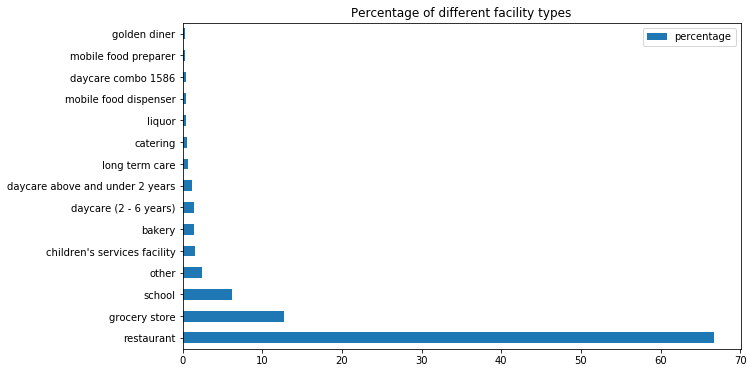

In [66]:
facility_type_percent.iloc[:15].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of different facility types')
plt.show()

**Observation**
- We can obserse that we have 437 different facility types, but only several facility types have percentage more than 1% and they constitute almost the whole dataset.
- We can observe that some establishments have several facility types and these establishments all have very small percentages(<<1%) in the whole dataset, so we decide to use the first facility type as these eatablishments' facility type to make life easier.

In [67]:
chicago_raw['Facility Type'] = chicago_raw['Facility Type'].apply(lambda x: str(x).split('/')[0].strip())
chicago_raw['Facility Type'] = chicago_raw['Facility Type'].apply(lambda x: str(x).split('&')[0].strip())

We extrat the top50 facility types as **facility_types_top50** and the remaining one as **facility_type_small**. And try to merge the facility types in **facility_type_small** to **facility_types_top50**, choose the one with the maximum Jaro-Winkler similarity.

In [68]:
facility_types = chicago_raw['Facility Type'].value_counts().index.tolist()
facility_types_top50 = facility_types[:50]
facility_type_small = facility_types[50:]

***Jaro-Winkler***
This algorithms gives high scores to two strings if \
(1) they contain the same characters, but within a certain distance from each another, AND \
(2) the order of the matching characters are the same. \
To be exact, the distance of finding similar character is one less than half the length of the longest string. So if the longest string has a length of 5, the character at the start of the string A must be found before or at the ((5/2)–1) ~ 2nd position in the string B to be considered as a valid match. Therefore, the algorithm is directional and gives high score if matching is from the beginning of the strings.

In [69]:
def generate_dict(valid_types, to_be_merged_types):
    '''
    Cluster less-frequent facility-type/inspection-type to manually selected frequent ones.
    
    Args:
        valid_types: facility-type/inspection-type appears frequently
        to_be_merged_types: the rest of types that needs to be merged
    
    Returns:
        A dictionary where the key is the less-frequent facitily-type/inspection-type and 
        the value is the corresponding frequent types
    '''
    dictionary = {}
    for i in to_be_merged_types:
        max_similarity = 0
        
        # find the one in valid types has the maximum similarity
        for j in valid_types:
            similarity = textdistance.jaro_winkler(i,j)
            if similarity > max_similarity:
                max_similarity = similarity;
                similar_type = j
        if max_similarity > 0.8:
            dictionary[i] = similar_type
    
    return dictionary

In [70]:
dictionary = generate_dict(facility_types_top50, facility_type_small)

In [71]:
def print_dict(dictionary):
    '''
    Further illustrate and explain the dictionary generated from function 'generate_dict'
    
    Args:
    dictionary: the dictionary generated from function 'generate_dict'
    '''
    
    print(">>>>>>>>>>>>>>>print 10 entries in the dictionary as example: <<<<<<<<<<<<<\n")
    count = 0
    for i in dictionary.keys():
        print("MERGE [%s] ---TO--- [%s]" % (i, dictionary[i]))
        count = count + 1
        if count > 10:
            return
print_dict(dictionary)

>>>>>>>>>>>>>>>print 10 entries in the dictionary as example: <<<<<<<<<<<<<

MERGE [culinary school] ---TO--- [charter school]
MERGE [1023-children's services facility] ---TO--- [children's services facility]
MERGE [rest] ---TO--- [restaurant]
MERGE [roof tops] ---TO--- [rooftop]
MERGE [paleteria] ---TO--- [cafeteria]
MERGE [mobile desserts vendor] ---TO--- [mobile frozen desserts vendor]
MERGE [roof top] ---TO--- [rooftop]
MERGE [hotel] ---TO--- [hospital]
MERGE [mobile food truck] ---TO--- [mobile food preparer]
MERGE [grocery(sushi prep)] ---TO--- [grocery]
MERGE [rooftops] ---TO--- [rooftop]


Merge the facility types which only have small percentages into the top50 facility types

In [72]:
def subsitute_similar_type(type_, dictionary, to_be_merged_type):
    '''
    This function is used in pd.Series.apply()
    
    Args:
        type_: the facility-type/inspeciton-type of a cell
        dictionary: the dictionary generated from function 'generate_dict'
        to_be_merged_type: the list of less-frequent facility-type/inspeciton-type that needs to be merged
    
    Returns:
        The centroid of this cell's type
    '''
    result = type_
    if type_ in to_be_merged_type:
        result = 'other'
        if type_ in dictionary.keys():
            result =  dictionary[type_]
    return result

chicago_raw['Facility Type'] = chicago_raw['Facility Type'].apply(lambda x: subsitute_similar_type(x, dictionary, facility_type_small))

In [73]:
# print the facility types after merge
chicago_raw['Facility Type'].value_counts().index

Index(['restaurant', 'grocery store', 'school', 'other',
       'children's services facility', 'bakery', 'daycare (2 - 6 years)',
       'daycare above and under 2 years', 'long term care', 'catering',
       'liquor', 'mobile food dispenser', 'daycare combo 1586',
       'mobile food preparer', 'hospital', 'golden diner', 'wholesale',
       'tavern', 'daycare (under 2 years)', 'special event', 'gas station',
       'grocery', 'banquet hall', 'shared kitchen user (long term)', 'banquet',
       'charter school', 'mobile prepared food vendor', 'shared kitchen',
       'kiosk', 'mobile frozen desserts vendor', 'rooftop', 'shelter',
       'live poultry', 'cafeteria', 'daycare', 'convenience store',
       'private school', '1023 childern's services facility', 'coffee shop',
       'church', 'convenience', 'navy pier kiosk', 'daycare (2 years)',
       'theater', 'ice cream shop', 'stadium', 'store',
       'shared kitchen user (short term)', 'bar', 'church kitchen'],
      dtype='objec

**Generate the clustered facility type mannaully**

In [74]:
restaurant = ['restaurant', 'catering', 'cafeteria', 'banquet', 'golden diner', 'banquet hall','special event']
grocery_store = ['grocery store', 'grocery', 'store', 'convenience store', 'convenience', 'kiosk', 'navy pier kiosk', 'gas station']
mobile_food = ['mobile food preparer', 'mobile food dispenser', 'mobile frozen desserts vendor', \
               'mobile prepared food vendor']
drink = ['liquor', 'tavern', 'rooftop', 'bar', 'coffee shop', 'ice cream shop']
bakery = ['bakery']
school = ['school', 'charter school', 'private school']
daycare = ["children's services facility", 'daycare (2 - 6 years)', 'daycare above and under 2 years', \
           'daycare (under 2 years)', 'daycare combo 1586', 'daycare', 'daycare (2 years)', '1023 childern\'s services facility']
long_term_care = ['long term care']
shared_kitchen = ['shared kitchen', 'shared kitchen user (long term)', 'shared kitchen user (short term)']
others = ['other', 'live poultry', 'hospital', 'wholesale', 'church', 'church kitchen', 'shelter', 'stadium', 'theater']

clustered_facility_type = [restaurant, grocery_store, mobile_food, drink, \
                           bakery, school, daycare, long_term_care, shared_kitchen, others]
types = ['resturant', 'grocery_store', 'mobile_food', 'drink', \
         'bakery', 'school', 'daycare', 'long_term_care', 'shared_kitchen', 'others']

In [75]:
def generate_clustered_type(facility_type):
    '''
    This function is used in pd.Series.apply()
    
    Args:
        facility_type: the facility-type of a cell
    
    Returns:
        The clustered facility type
    '''
    for ind, clustered_type in enumerate(clustered_facility_type):
        if facility_type in clustered_type:
            return types[ind]
        
chicago_raw['Facility Type'] = chicago_raw['Facility Type'].apply(generate_clustered_type)

In [76]:
chicago_raw['Facility Type'].value_counts()

resturant         132873
grocery_store      25739
school             12309
daycare             9393
others              7386
bakery              2880
mobile_food         1619
drink               1454
long_term_care      1371
shared_kitchen       317
Name: Facility Type, dtype: int64

**Observe**  
After clustering the facility types mannually, now we have 10 clustered facility types.

### 1.13. Inpection Type <a name="inspection_type"></a>

In [77]:
chicago_raw['Inspection Type'] = chicago_raw['Inspection Type'].str.lower()
print('The number of different inspection types: ', chicago_raw['Inspection Type'].nunique())
print('The number of NaN in the inspection Type column: ', chicago_raw['Inspection Type'].isnull().sum())

The number of different inspection types:  96
The number of NaN in the inspection Type column:  1


In [78]:
chicago_raw['Inspection Type'].fillna('other', inplace=True)

In [79]:
inspection_type_percent = pd.DataFrame({'count': chicago_raw['Inspection Type'].value_counts(),\
                                        'percentage':(chicago_raw['Inspection Type'].value_counts()/chicago_raw['Inspection Type'].count())*100})
print('>>>>>>>>>>>>>>>The total number of types of inspection type is %d<<<<<<<<<<<<<<<<<<<<' % inspection_type_percent.shape[0])
inspection_type_percent.head(10)

>>>>>>>>>>>>>>>The total number of types of inspection type is 97<<<<<<<<<<<<<<<<<<<<


count  percentage
canvass                   103222   52.841953
license                    25757   13.185660
canvass re-inspection      20570   10.530303
complaint                  18129    9.280694
license re-inspection       8937    4.575076
complaint re-inspection     7536    3.857869
short form complaint        6732    3.446281
suspected food poisoning     849    0.434625
consultation                 668    0.341966
license-task force           605    0.309715

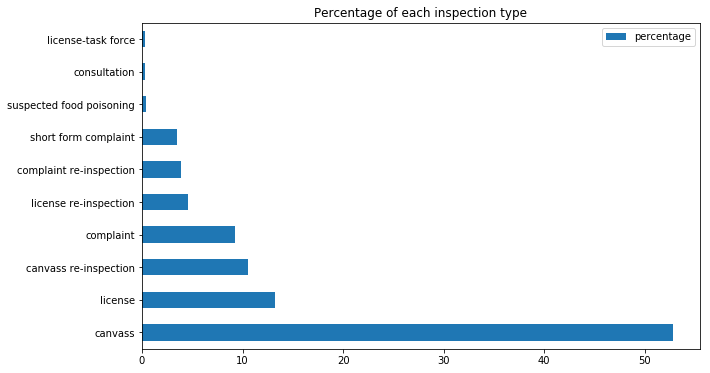

In [80]:
# show the top10 inspection types
inspection_type_percent.iloc[:10].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of each inspection type')
plt.show()

**Observation**
- We can obserse that we have 97 different inspection types, but only several inspection types have inspection records more than 10 and they constitute almost the whole dataset.

We extrat the inspection types which have more than 10 inspection records as **valid_inspection** and the remaining one as **to_be_merged_inspection_type**. And try to merge the inspection types in **to_be_merged_inspection_type** to **valid_inspection_type**, choose the one with the maximum Jaro-Winkler similarity.

In [81]:
valid_inspection_type = inspection_type_percent[inspection_type_percent['count'] > 10].index.tolist()
to_be_merged_inspection_type = inspection_type_percent[inspection_type_percent['count'] <= 10].index.tolist()

In [82]:
dictionary = generate_dict(valid_inspection_type, to_be_merged_inspection_type)
print_dict(dictionary)

>>>>>>>>>>>>>>>print 10 entries in the dictionary as example: <<<<<<<<<<<<<

MERGE [sfp/complaint] ---TO--- [complaint]
MERGE [license consultation] ---TO--- [pre-license consultation]
MERGE [task force] ---TO--- [task force liquor 1475]
MERGE [license/not ready] ---TO--- [license]
MERGE [task force liquor 1474] ---TO--- [task force liquor 1475]
MERGE [reinspection] ---TO--- [recent inspection]
MERGE [task force liquor 1470] ---TO--- [task force liquor 1475]
MERGE [license renewal for daycare] ---TO--- [license]
MERGE [canvass special events] ---TO--- [canvass]
MERGE [license canceled by owner] ---TO--- [license]
MERGE [license wrong address] ---TO--- [license]


In [83]:
chicago_raw['Inspection Type'] = chicago_raw['Inspection Type']\
                                .apply(lambda x: subsitute_similar_type(x, dictionary, to_be_merged_inspection_type))

In [84]:
chicago_raw['Inspection Type'].unique()

array(['canvass re-inspection', 'license', 'license re-inspection',
       'canvass', 'complaint re-inspection', 'complaint',
       'short form complaint', 'recent inspection',
       'suspected food poisoning',
       'suspected food poisoning re-inspection', 'not ready',
       'consultation', 'non-inspection', 'special events (festivals)',
       'other', 'tag removal', 'license-task force',
       'complaint-fire re-inspection', 'complaint-fire',
       'short form fire-complaint', 'pre-license consultation',
       'task force liquor 1475', 'package liquor 1474', 'out of business',
       'no entry', 'license request'], dtype=object)

**Inspection type:**   
An inspection can be one of the following types:   
**canvass**, the most common type of inspection performed at a frequency relative to the risk of the establishment;  
**consultation**, when the inspection is done at the request of the owner prior to the opening of the establishment;  
**complaint**, when the inspection is done in response to a complaint against the establishment;  
**license**, when the inspection is done as a requirement for the establishment to receive its license to operate;  
**suspect food poisoning**, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection);  
**task-force inspection**, when an inspection of a bar or tavern is done.  
**Re-inspections** can occur for most types of these inspections and are indicated as such.  

**Generate the clustered inspection type mannaully**

In [87]:
cavass = ['canvass', 'recent inspection',]
complaint = ['complaint', 'short form complaint', 'complaint-fire', 'short form fire-complaint']
license = ['license', 'license request']
suspect_food_poisoning = ['suspected food poisoning']
consultation = ['consultation', 'pre-license consultation']
task_force = ['license-task force', 'task force liquor 1475', 'package liquor 1474']

cavass_reinpection = ['canvass re-inspection']
complaint_reinpection = ['complaint re-inspection', 'complaint-fire re-inspection']
license_reinpection = ['license re-inspection']
suspect_food_poisoning_reinpection = ['suspected food poisoning re-inspection']

others = ['not ready', 'non-inspection', 'special events (festivals)', 'other', 'tag removal', 'out of business', 'no entry']

clustered_inspection_type = [cavass, complaint, license, suspect_food_poisoning, \
                             consultation, task_force, cavass_reinpection, complaint_reinpection,\
                             license_reinpection, suspect_food_poisoning_reinpection, others]
types = ['cavass', 'complaint', 'license', 'suspect_food_poisoning', \
         'consultation', 'task_force', 'cavass_reinpection', 'complaint_reinpection',\
         'license_reinpection', 'suspect_food_poisoning_reinpection', 'others']

In [88]:
def generate_clustered_type(inspection_type):
    '''
    This function is used in pd.Series.apply()
    
    Args:
        facility_type: the inspection-type of a cell
    
    Returns:
        The clustered inspection type
    '''
    for ind, clustered_type in enumerate(clustered_inspection_type):
        if inspection_type in clustered_type:
            return types[ind]
        
chicago_raw['Inspection Type'] = chicago_raw['Inspection Type'].apply(generate_clustered_type)

In [89]:
chicago_raw['Inspection Type'].value_counts()

cavass                                103562
license                                25784
complaint                              25141
cavass_reinpection                     20572
license_reinpection                     8939
complaint_reinpection                   7580
others                                  1118
task_force                               919
suspect_food_poisoning                   849
consultation                             686
suspect_food_poisoning_reinpection       191
Name: Inspection Type, dtype: int64

After cluster the inspection types mannually, now we have 11 clustered inspection types.

**Now we have finished the cleaning of the dataset and we write out to pickle for later use**

In [91]:
chicago_raw.to_pickle(CHICAGO_PICKLE_PATH)

# 2. Exploratory Data Analysis <a name="data_exploration"></a>

In [3]:
GEOJSON_ZIP_PATH = 'data_raw/Boundaries - ZIP Codes.geojson'

**Load cleaned data**

In [4]:
with open(CHICAGO_PICKLE_PATH, 'rb') as f:
    chicago = pickle.load(f)
print('The shape of cleaned chicago food inspection dataset: ', chicago.shape)
chicago.head(3)

The shape of cleaned chicago food inspection dataset:  (195341, 17)


Inspection ID                       DBA Name                      AKA Name  \
0        2345318                         subway                        subway   
1        2345334  la michoacana  ice cream shop  la michoacana ice cream shop   
2        2345339                 the crepe shop                the crepe shop   

   License # Facility Type           Risk                     Address    Zip  \
0  2529116.0     resturant  risk 1 (high)    2620 n narragansett ave   60639   
1  2698396.0     resturant  risk 1 (high)  3591-3597 n milwaukee ave   60641   
2  2699005.0     resturant  risk 1 (high)            2934 n broadway   60657   

  Inspection Date     Inspection Type             Results  \
0      2019-11-08  cavass_reinpection  pass w/ conditions   
1      2019-11-08             license  pass w/ conditions   
2      2019-11-08             license                fail   

                                          Violations   Latitude  Longitude  \
0  3. management, food employee and conditional e...  41.927995 -87.785752   
1  3. management, food employee and conditional e...  41.946140 -87.735183   
2  10. adequate handwashing sinks properly suppli...  41.935930 -87.644407   

          Violations Number       Community Rule Version  
0                [3, 5, 58]  BELMONT CRAGIN          new  
1            [3, 5, 51, 57]     IRVING PARK          new  
2  [10, 39, 48, 51, 53, 55]       LAKE VIEW          new

## 2.1. Overview <a name="overview2"></a>

Calculate the number of establishments in each `Zip`

In [5]:
chicago_establishments = chicago.drop_duplicates(subset='License #', keep="last")
establishments_in_zip = chicago_establishments.groupby('Zip').count()[['License #']].rename(columns={'License #':'counts'})
establishments_in_zip = establishments_in_zip.reset_index()
establishments_in_zip['Zip'] = establishments_in_zip.Zip.astype(str)
establishments_in_zip.head(3)

Zip  counts
0  60601     594
1  60602     244
2  60603     367

Download `Chicago zip codes bundaries` from the Chicago official website used for plot map.\
Source: https://www.chicago.gov/city/en/depts/doit/dataset/boundaries_-_zipcodes.html 

In [6]:
geo = json.load(open(GEOJSON_ZIP_PATH))
chicago_coord = [chicago['Latitude'].mean(), chicago['Longitude'].mean()]

In [7]:
chicago_map = folium.Map(location=chicago_coord,tiles='cartodbpositron')
folium.Choropleth(geo_data=geo, name='choropleth', data=establishments_in_zip,
             columns=['Zip', 'counts'],
             key_on='feature.properties.zip',
             fill_color='YlOrRd',
             fill_opacity=1,
             line_opacity=0.2,
             legend_name= 'Number of establishments').add_to(chicago_map)
folium.LayerControl().add_to(chicago_map)
chicago_map.save('image/establishment_map.html')

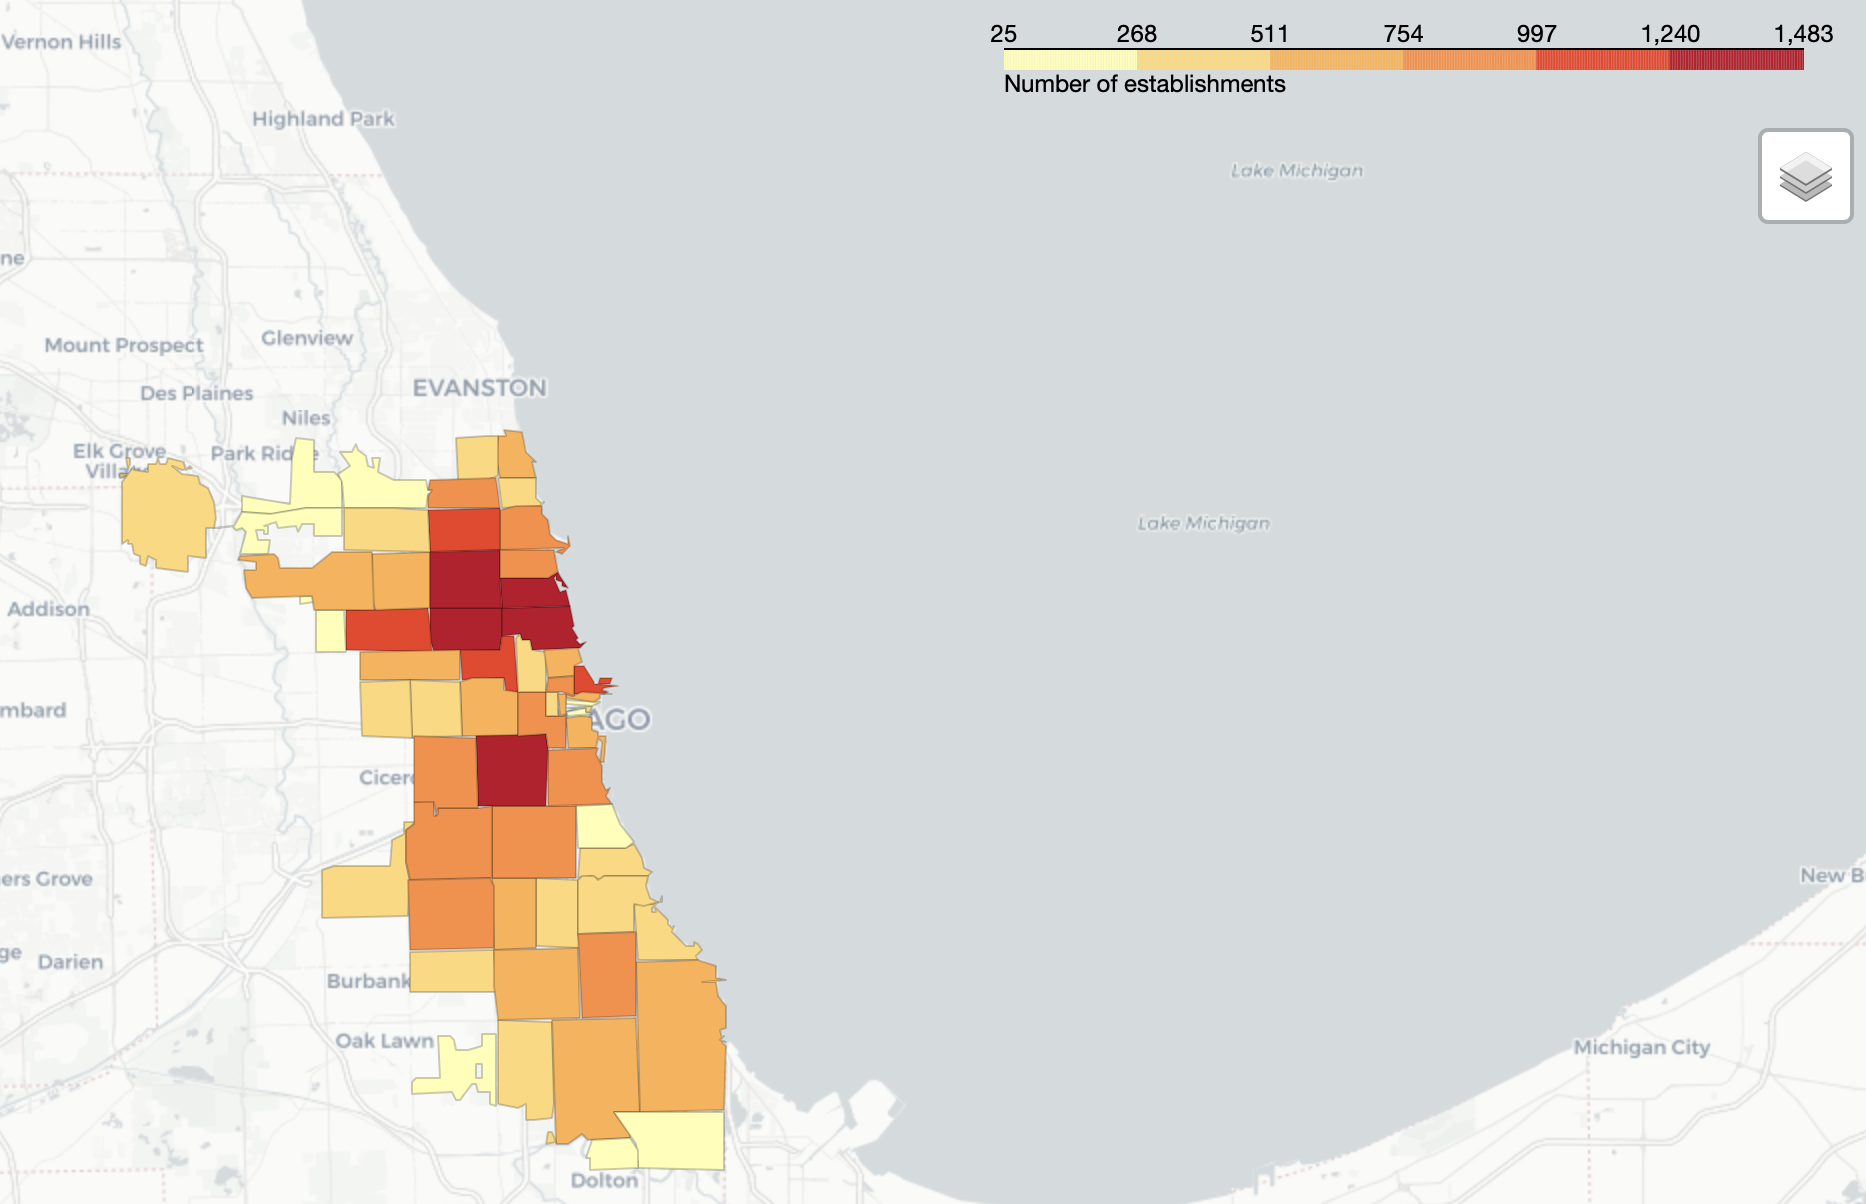

In [8]:
Image(filename='image/establishment_map.png')

**Observation**  
From the map plot, we can observe that some Zip areas have more food establishments than the others, so when we do the analysis later for each area, sometimes we may need to do the normalization.

**Plot the distrubution of inspections by risk**

Text(0,0.5,'Latitude')

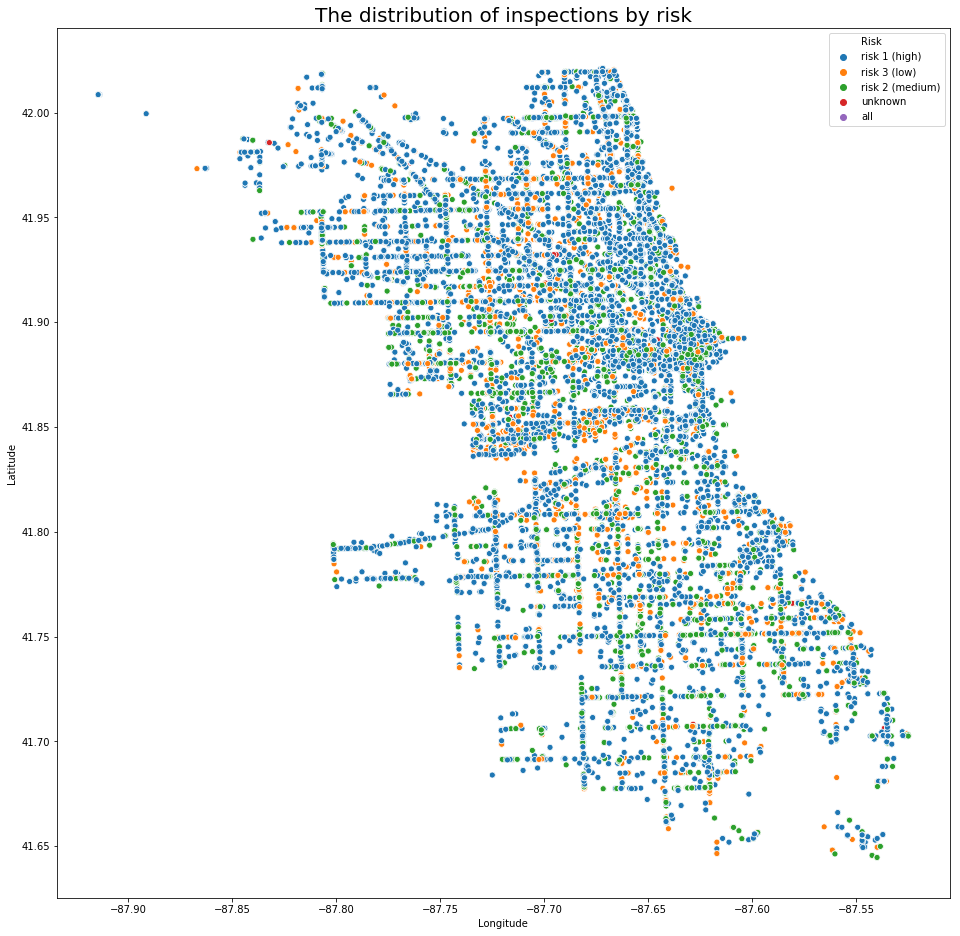

In [11]:
fig, ax = plt.subplots(figsize=(16,16))
sns.scatterplot(x='Longitude',y='Latitude',hue='Risk', data=chicago, ax=ax)
ax.set_title("The distribution of inspections by risk",size=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

**Observation**  
From the distribution of inspections, we can observe:   
1. Where there are more food establishments there are more inspections have been taken.
2. The number of Inspections for Risk_1 food establisments is more than Risk_2/Risk_3 as we expected.

**Plot the number of inspection by month and year seperately**

In [14]:
chicago['year'] = chicago['Inspection Date'].dt.year
chicago['month'] = chicago['Inspection Date'].dt.month
chicago['day'] = chicago['Inspection Date'].dt.day

Text(0.5,0,'')

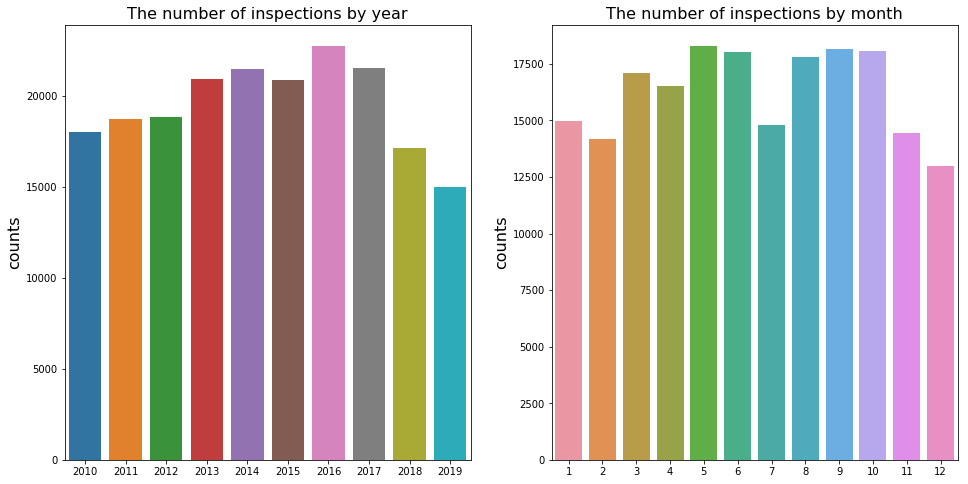

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
x = chicago.year.value_counts().index
y = chicago.year.value_counts()
sns.barplot(x=x,y=y,ax=ax[0])
ax[0].set_title("The number of inspections by year",size=16)
ax[0].set_ylabel('counts',size=16)
ax[0].set_xlabel('')

x = chicago.month.value_counts().index
y = chicago.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[1])
ax[1].set_title("The number of inspections by month",size=16)
ax[1].set_ylabel('counts',size=16)
ax[1].set_xlabel('')

## 2.2.  Analysis by time <a name="analysis_by_time"></a>

#### Is there a yearly pattern for inspection results? <a name="year"></a>

In [16]:
inspection_results_percent = pd.DataFrame({'count': chicago['Results'].value_counts(), \
                                      'percentage':(chicago['Results'].value_counts()/chicago['Results'].count())*100})
print('>>>>>>>>>>>>>>The total number of types of Inspection results is %d<<<<<<<<<<<<<' % inspection_results_percent.shape[0])
inspection_results_percent

>>>>>>>>>>>>>>The total number of types of Inspection results is 6<<<<<<<<<<<<<


count  percentage
pass                105571   54.044466
fail                 37790   19.345657
pass w/ conditions   27011   13.827614
out of business      16879    8.640787
no entry              6221    3.184687
not ready             1869    0.956788

Here we consider three types of inspection results: **pass**, **pass w/conditions** and **fail**, and these three types constitute almost 90% of the inspection results.

In [17]:
chicago_rate = chicago.loc[chicago['Results'].isin(['pass', 'fail', 'pass w/ conditions'])]
chicago_rate.shape

(170372, 20)

In [18]:
grouped_by_year = chicago_rate.groupby(['year'])\
                              .count()[['Inspection ID']]\
                              .rename(columns={"Inspection ID": "# inspection/year"})
grouped_by_year.head(3)

# inspection/year
year                   
2010              17348
2011              17563
2012              15987

In [19]:
grouped_year_reaults = chicago_rate.groupby(['year', 'Results'])\
                                   .count()[['Inspection ID']]\
                                   .rename(columns={"Inspection ID": "#time"})

grouped_year_reaults.reset_index(level = 1, inplace = True)
grouped_year_reaults.head()

Results  #time
year                           
2010                fail   4491
2010                pass  11434
2010  pass w/ conditions   1423
2011                fail   4352
2011                pass  11695

In [20]:
grouped_merged = grouped_year_reaults.merge(grouped_by_year, on=['year'], how = 'right')
grouped_merged["rate"] = grouped_merged["#time"]/grouped_merged["# inspection/year"]
grouped_merged.head()

Results  #time  # inspection/year      rate
year                                                        
2010                fail   4491              17348  0.258877
2010                pass  11434              17348  0.659096
2010  pass w/ conditions   1423              17348  0.082027
2011                fail   4352              17563  0.247794
2011                pass  11695              17563  0.665889

In [21]:
fail_pass_rate_per_year = grouped_merged.pivot(columns='Results', values='rate')
fail_pass_rate_per_year.head()

Results      fail      pass  pass w/ conditions
year                                           
2010     0.258877  0.659096            0.082027
2011     0.247794  0.665889            0.086318
2012     0.227560  0.676737            0.095703
2013     0.196198  0.701009            0.102793
2014     0.199839  0.676278            0.123884

In [22]:
def compute_plot(data,xlabel,ylabel,title, flag):
    """Plot the Pass, Fail and Pass With Conditions rate with respect to the index of data
    
    Args:
        data (Pandas dataframe): the dataset returned from function 'compute_rate'
        xlabel (str): the name of x axis
        ylabel (str): the name of y axis
        title (str): title of the plot
        flag (boolean): plot the tendency line of 'Fail' or not
    """
    fig, ax = plt.subplots(figsize=(10,7))
    w = 0.2
    x = data.index
    ax.bar(x-w, data['pass'], width=w, color='b',label='Pass')
    ax.plot(x-w, data['pass'], '-o', color='orange')
    ax.bar(x, -data['fail'], width=w, color='g',label='Fail')
    if flag:
        ax.plot(x, -data['fail'], '-o', color='orange')
    ax.bar(x+w, -data['pass w/ conditions'], width=w, color='r',label='pass w/ conditions')
    ax.legend(bbox_to_anchor=(1.3, 0.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

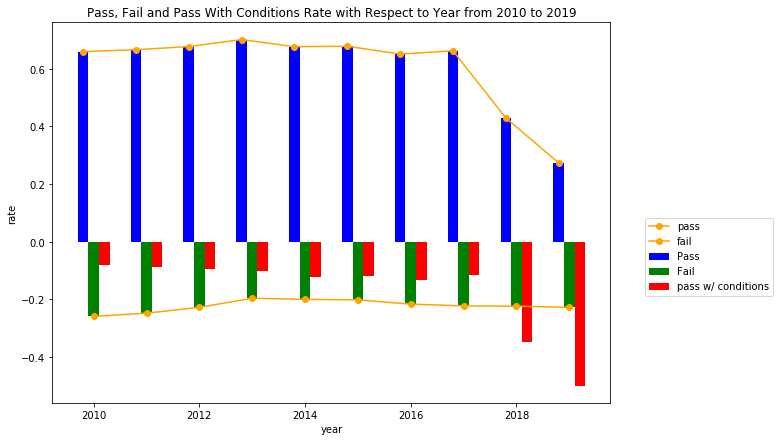

In [23]:
compute_plot(fail_pass_rate_per_year,'year','rate','Pass, Fail and Pass With Conditions Rate with Respect to Year from 2010 to 2019', True)

**Analysis**  
According to Chicago Department of Public Health, the scheme used for inspection has a major change on July 1st, 2018. This is also reflected in the plot, from 2018 it sees a significant change of results. The **pass rate** has dropped significantly, which is compensated by a dramatically increasing **pass with conditions** rate. This can be interpreted as a much **stricter scheme** which discovers more problems that can be solved during the inspection.The **fail rate** slightly decreases with respect to year, indicating that the overall cleaniess situation of Chicago's food industry is improving.

**Helper Function to calculate pass rate, fail rate and pass w/conditions rate**  
Since we will need to calculate the pass rate, fail rate and pass w/condition rate according to different features **(year, month, facility type, inspection type)** many times. We generate a helper function from the previous steps and reuse the function.

In [24]:
def compute_rate(data, feature):
    """Compute the pass, pass with condition and fail rate grouped by this specific feature. 
    
    Args:
        data (Pandas dataframe): the dataset used to calculate the pass, pass with condition and fail rate
        feature (str): on which feature we wish to group by
    
    Returns:
        final_df: a dataframe with the index being categories of the feature column and the columns
                  being pass rate, fail rate and pass with condition rate
    """
    # The total number of inspections grouped by features
    grouped = data.groupby([feature])\
                  .count()[['Inspection ID']]\
                  .rename(columns={"Inspection ID": "#inspection"})
    
    # The number of Pass, Fail and Pass With Conditions respectively
    grouped_by = data.groupby([feature, 'Results'])\
                     .count()[['Inspection ID']]\
                     .rename(columns={"Inspection ID": "#time"})
    grouped_by.reset_index(level = 1, inplace = True)
    
    grouped_merged = grouped_by.merge(grouped, on=[feature], how = 'right')
    grouped_merged["rate"] = grouped_merged["#time"]/grouped_merged["#inspection"]
    
    final_df = grouped_merged.pivot(columns='Results', values='rate')
    return final_df

#### Is there a monthly pattern for inspection results? <a name="month"></a>

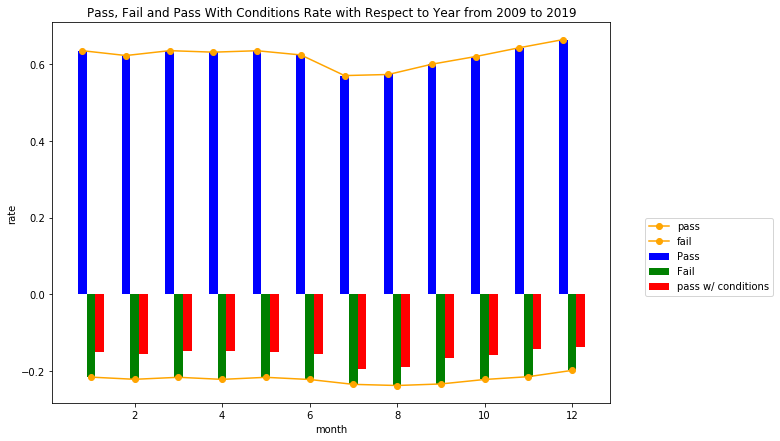

In [25]:
rate_per_month = compute_rate(chicago_rate,'month')
compute_plot(rate_per_month,'month','rate','Pass, Fail and Pass With Conditions Rate with Respect to Year from 2009 to 2019', True)

**Observation**: The distribution of the rates over months is in general smooth. However, in the **summer** (July and August), the pass rate is apprarently lower than the other months and the pass with condition rate is slightly higher than the other months.

## 2.3. Analysis by Facility Type <a name="analysis_by_facility_type"></a>

In [26]:
facility_type_rate = compute_rate(chicago_rate,'Facility Type')
facility_type_rate

Results             fail      pass  pass w/ conditions
Facility Type                                         
bakery          0.244163  0.622873            0.132964
daycare         0.202067  0.676693            0.121240
drink           0.356753  0.563622            0.079625
grocery_store   0.267543  0.599235            0.133222
long_term_care  0.233359  0.586075            0.180566
mobile_food     0.305882  0.595156            0.098962
others          0.319022  0.571004            0.109974
resturant       0.211071  0.611874            0.177055
school          0.202437  0.712185            0.085378
shared_kitchen  0.082781  0.864238            0.052980

(0, 1)

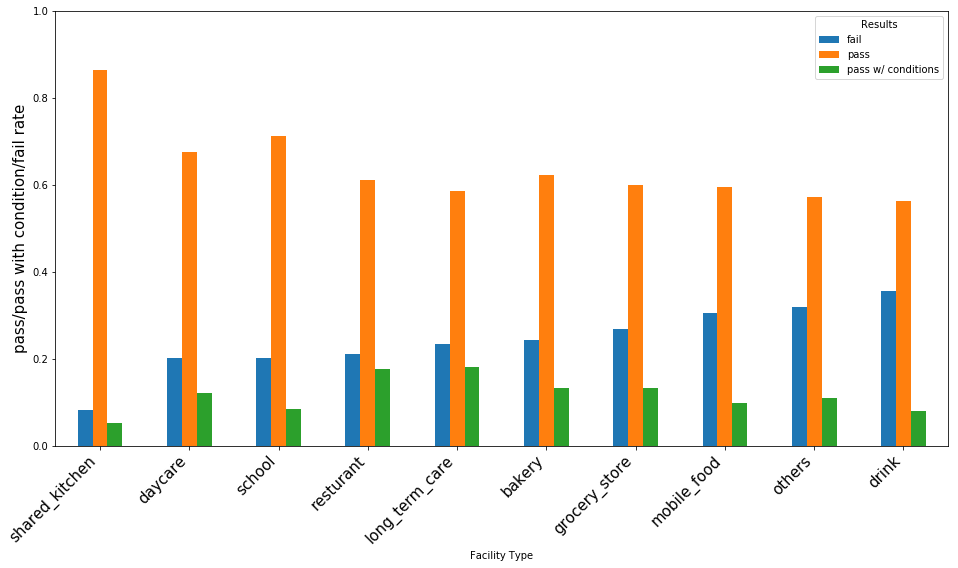

In [27]:
facility_type_rate.sort_values(by = 'fail').plot(kind = 'bar', figsize=(16,8))
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize=15,
)
plt.ylabel('pass/pass with condition/fail rate', fontsize=15)
plt.ylim([0,1])

**Observation**  
We can observe that **shared kitchen** has a relatively good hygiene. Among the other facility types, **school** and **daycare** have better hygiene, while **drink** and **mobile** have poor hygiene. The figure above also shows that formal large restaurants are indeed cleaner than smaller mobile vendors.

## 2.4. Analysis by Inspection Type <a name="analysis_by_inspection_type"></a>

In [28]:
inspection_type_rate = compute_rate(chicago_rate,'Inspection Type')
inspection_type_rate

Results                                 fail      pass  pass w/ conditions
Inspection Type                                                           
cavass                              0.214421  0.593614            0.191965
cavass_reinpection                  0.067933  0.807745            0.124322
complaint                           0.284263  0.516373            0.199364
complaint_reinpection               0.096779  0.770619            0.132603
consultation                        0.184799  0.631893            0.183308
license                             0.382916  0.545540            0.071544
license_reinpection                 0.118569  0.811033            0.070397
others                              0.211397  0.617647            0.170956
suspect_food_poisoning              0.256257  0.468415            0.275328
suspect_food_poisoning_reinpection  0.057592  0.837696            0.104712
task_force                          0.569248  0.430752                 NaN

(0, 1)

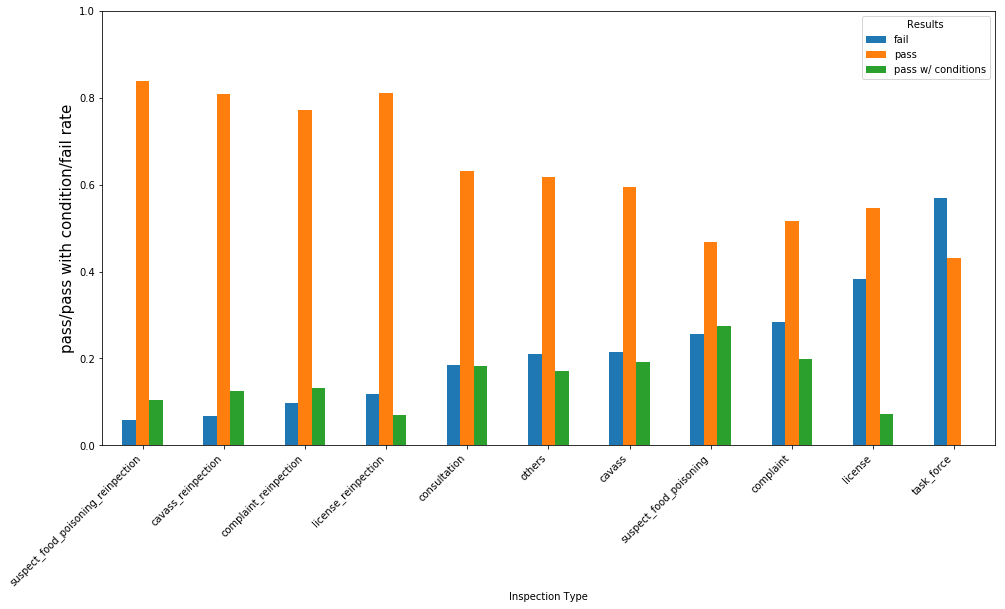

In [29]:
inspection_type_rate.sort_values(by = 'fail').plot(kind = 'bar', figsize=(16,8))
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=10)
plt.ylabel('pass/pass with condition/fail rate', fontsize=15)
plt.ylim([0,1])

**Observation**  
1. We can observe that the **fail rate** of **re-inspections** are always lower than other type of inspections
2. In the types of non-re-inspection, **consultation** has the lowest fail rate. Consultation is done at the request of the owner prior to the openning of the establishment so we can assume the hygiene situation of the eatablishments  will be good at this satge.
3. The fail rate of **license** inspection is high. **License** is done as a requirement for the establishment to receive its license to operate. There might be two reasons for this high fail rate, One is that the inspection is stricter when related to the license acquirement, the other might because the establishment has not become familiar with the food inspection rules at that stage and thus has many aspects to improve about their food hygiene. 
4. **Task-force inspection** has the highest fail rate. This is coincident with our observation above that **Drink** facility type has the highest fail rate.

## 2.5. Analysis by Community Area<a name="analysis_by_community_area"></a>

There are totally 77 communities in Chicago. From the perspective of communities, the fail rate is used as the metric as it distinguishes the communities most distinctly. 

We categorise communities of Chicago into three regions based on https://en.wikipedia.org/wiki/Community_areas_in_Chicago as below:
1. Downtown: Humboldt Park, West Town, Near North Side, Near West Side, Loop, North Lawndale, East Garfield Park, West Garfield Park.
2. North: The communities on the north of Downtown.
3. South: The communities on the south of Downtown.

**Plot the map to show how we define the `North`, `Center` and `South`**

In [114]:
north = ['North Center','Lake View','Lincoln Park','Avondale','Logan Square','Rogers Park','West Ridge','Uptown',
 'Lincoln Square','Edison Park','Norwood Park','Jefferson Park','Forest Glen','North Park','Albany Park',
 "OHare",'Edgewater','Portage Park','Irving Park','Dunning','Montclare','Belmont Cragin','Hermosa','Austin']
center = ['Humboldt Park','West Town','Near North Side','Near West Side','Loop','North Lawndale','East Garfield Park','West Garfield Park']
south = ['South Lawndale', 'Lower West Side', 'Douglas', 'Near South Side', 'Armour Square', 'Oakland', 'Fuller Park','Grand Boulevard',
'Kenwood','Washington Park','Hyde Park','Woodlawn','South Shore','Bridgeport','Greater Grand Crossing','Garfield Ridge','Archer Heights',
'Brighton Park','McKinley Park','New City','West Elsdon','Gage Park','Clearing','West Lawn','Chicago Lawn','West Englewood','Englewood',
'Chatham','Avalon Park','South Chicago','Burnside','Calumet Heights','Roseland','Pullman','South Deering','East Side',
'West Pullman','Riverdale','Hegewisch','Ashburn','Auburn Gresham','Beverly','Washington Heights','Mount Greenwood','Morgan Park']

In [115]:
north = [x.upper() for x in north]
center = [x.upper() for x in center]
south = [x.upper() for x in south]

areaN = pd.DataFrame()
areaN['Community'] = north
areaN['region'] = 0
areaN['where'] = 'North'
areaN.Community.nunique()

areaC = pd.DataFrame()
areaC['Community'] = center
areaC['region'] = 1
areaC['where'] = 'Center'
areaC.Community.nunique()

areaS = pd.DataFrame()
areaS['Community'] = south
areaS['region'] = 2
areaS['where'] = 'South'
areaS.Community.nunique()

area = areaN.append(areaC, ignore_index=True)
area = area.append(areaS, ignore_index=True)
area.head(3)

Community  region  where
0  NORTH CENTER       0  North
1     LAKE VIEW       0  North
2  LINCOLN PARK       0  North

In order to plot, we merge the **Area_information** dataset with **geometry information** data

In [56]:
df = gpd.GeoDataFrame(columns=['Community', 'geometry'], geometry='geometry')
geo_comm = json.load(open('data_raw/Boundaries - Community Areas (current).geojson'))
for i in range(len(geo_comm['features'])):
    data = {'Community':geo_comm['features'][i]['properties']['community'],
       'geometry':Polygon(geo_comm['features'][i]['geometry']['coordinates'][0][0])}
    df.loc[i] = data
data = df.merge(area, on='Community')
data.crs = {'init' :"epsg:4326"}
data.to_pickle('data_cleaned/data.pkl')

In [57]:
with open('data_cleaned/data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head(3)

Community                                           geometry  region  \
0      DOUGLAS  POLYGON ((-87.60914 41.84469, -87.60915 41.844...       2   
1      OAKLAND  POLYGON ((-87.59215 41.81693, -87.59231 41.816...       2   
2  FULLER PARK  POLYGON ((-87.62880 41.80189, -87.62879 41.801...       2   

   where  
0  South  
1  South  
2  South

In [43]:
mymap = folium.Map(location=[chicago['Latitude'].mean(), chicago['Longitude'].mean()], zoom_start=10)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

folium.Choropleth(
    geo_data=data,
    name='Choropleth',
    data=data,
    columns=['Community', 'region'],
    key_on='feature.properties.Community',
    fill_color='YlOrRd',
    fill_opacity=1,
    line_opacity=0.2,
#     legend_name='Pass Rate',
    smooth_factor=0,
    overlay=True
).add_to(mymap)

style_function = lambda x: {'fillColor': '#111111', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Community', 'where'],
        aliases=['Community: ','Region: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mymap.add_child(NIL)
mymap.keep_in_front(NIL)

folium.LayerControl().add_to(mymap)

mymap.save("image/community_region.html")

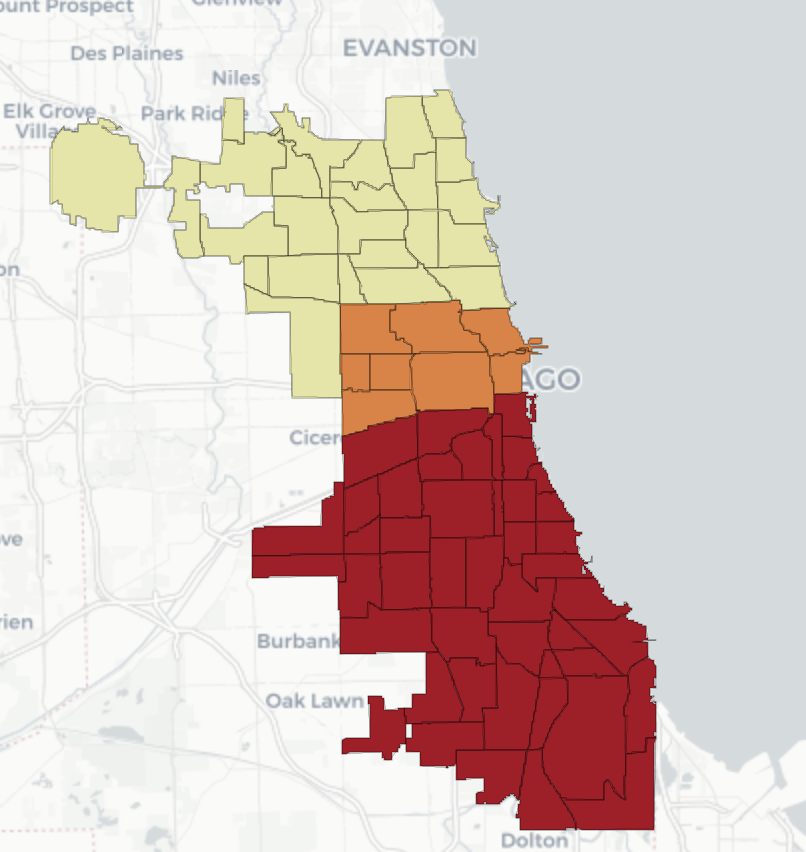

In [44]:
Image(filename='image/community_region.png')

**Plot distribution of fail rate over each Community area.**

In [58]:
Community_rate = compute_rate(chicago_rate, 'Community')
Community_rate = Community_rate.reset_index()
Community_rate['Community'] = Community_rate.Community.astype(str)
Community_rate.head()

Results       Community      fail      pass  pass w/ conditions
0           ALBANY PARK  0.239943  0.608402            0.151655
1        ARCHER HEIGHTS  0.221339  0.611805            0.166856
2         ARMOUR SQUARE  0.263821  0.596341            0.139837
3               ASHBURN  0.160740  0.700569            0.138691
4        AUBURN GRESHAM  0.274341  0.607505            0.118154

In [59]:
data = data.merge(Community_rate, on='Community')
max_fail = 0.3687707641196013
min_fail = 0.13532763532763534
fail_1 = ((max_fail-min_fail)/7)+min_fail
fail_2 = (2*(max_fail-min_fail)/7) +min_fail
fail_3 = (3*(max_fail-min_fail)/7) +min_fail
fail_4 = (4*(max_fail-min_fail)/7) +min_fail
fail_5 = (5*(max_fail-min_fail)/7) +min_fail
fail_6 = (6*(max_fail-min_fail)/7) +min_fail

def my_color_function(feature):
    """
    Maps low values to green and hugh values to red.
    """
    community_name = feature['properties']['community']
    if(data[data['Community'] ==community_name].fail.iloc[0] <= fail_1):
        return'#FFFFB2'
    elif(data[data['Community'] ==community_name].fail.iloc[0] <= fail_2):
        return '#FED976'
    elif(data[data['Community'] ==community_name].fail.iloc[0] <= fail_3):
        return '#FEB24C'
    elif(data[data['Community'] ==community_name].fail.iloc[0] <= fail_4):
        return '#FD8D3C'
    elif(data[data['Community'] ==community_name].fail.iloc[0] <= fail_5):
        return '#FC4E2A'
    elif(data[data['Community'] ==community_name].fail.iloc[0] <= fail_6):
        return '#E31A1C'
    else:
        return '#B10026'
    
m = folium.Map(location=[chicago['Latitude'].mean()-0.04, chicago['Longitude'].mean()], zoom_start=10)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

from branca.colormap import LinearColormap

colormap = LinearColormap(
    colors=['#B10026','#E31A1C','#FC4E2A','#FD8D3C','#FEB24C','#FED976','#FFFFB2'], 
    )
colormap.caption = 'Fail Rate'
colormap.add_to(m)

folium.GeoJson(
    geo_comm,
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'fillOpacity': 1, 
        'color' : my_color_function(feature),
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(m)
 
style_function = lambda x: {'fillColor': '#111111', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Community', 'fail'],
        aliases=['Community: ','Fail: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)

folium.LayerControl().add_to(m)
m.save("image/fail_rate.html")

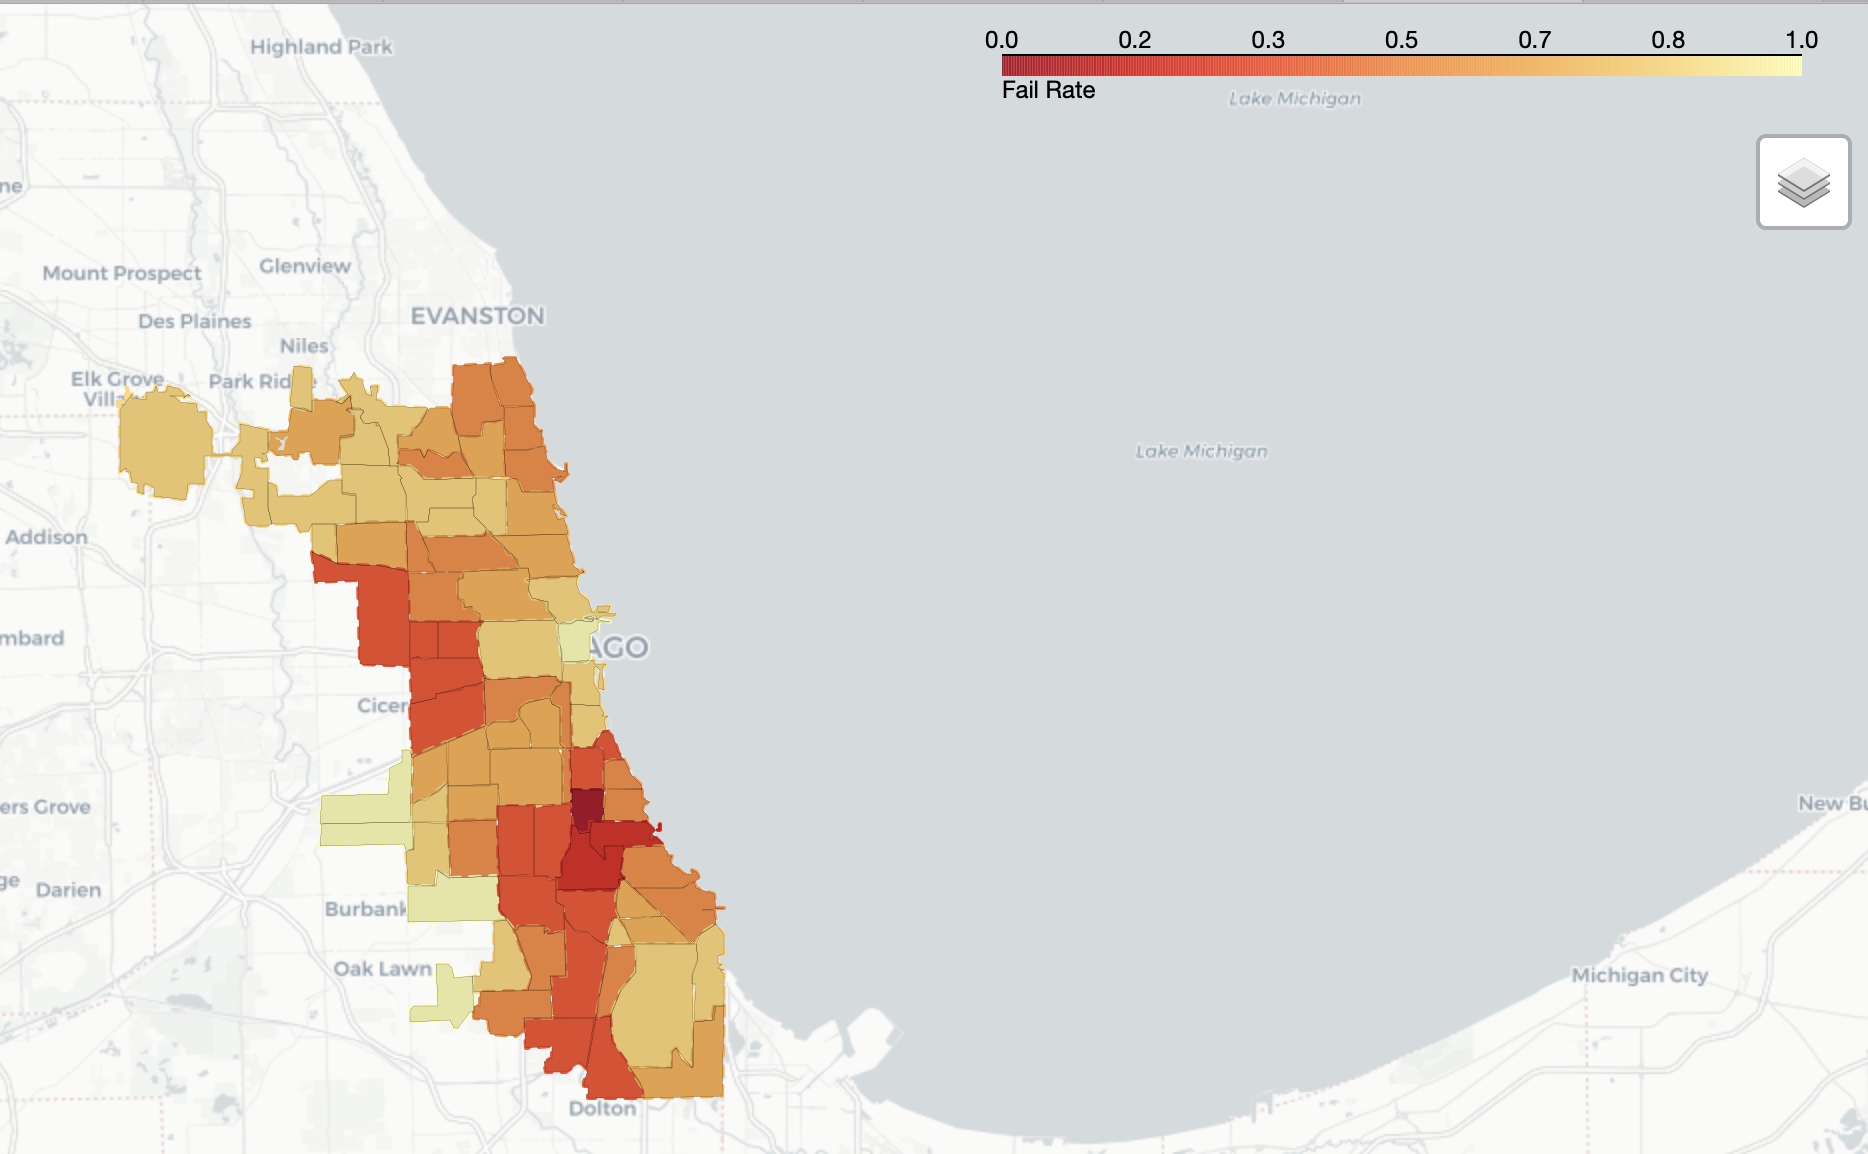

In [60]:
Image(filename='image/fail_rate.png')

**Observation**  
For the location of the restaurant, we mainly judge whether it is clean by analyzing the fail rates of different communities. We can roughly conclude that `north` is cleaner than `Center` and `South`. To do further analysis, we use the data of **Chicago life expectancy** and **Crime**. 

# 3. Chicago Crime Dataset and Life Expectancy<a name="Crime"></a>

Source of `Chicago Crime` dataset: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2 \
Source of `Life Expectancy` dataset: https://www.chicagohealthatlas.org/indicators/life-expectancy

## 3.1. Life Expectancy<a name="life"></a>
### Data Cleaning

Pre-process the Life Expectancy of Chicago in Each Community to match with our map's geo-data. 

This dataset contains information about the life expectancy for residents in Chicago from 2010 to 2017.

In [100]:
chicago_life_raw = pd.read_excel('data_raw/Life_Expectancy.xlsx').replace({'6-Lakeview': '6-LAKE VIEW', '76-O\'Hare': '76-OHARE'})
chicago_life_raw.head(3)

Category       SubCategory        Indicator  Year Geography Geo_Group  \
0  Mortality  Quality of Life   Life expectancy  2010      City   Chicago   
1  Mortality  Quality of Life   Life expectancy  2010      City   Chicago   
2  Mortality  Quality of Life   Life expectancy  2010      City   Chicago   

   Geo_ID      Demography                              Demo_Group  Number  \
0     606  Race-ethnicity                    All race-ethnicities    77.8   
1     606  Race-ethnicity                      Hispanic or Latino    84.7   
2     606  Race-ethnicity  Non-Hispanic Asian or Pacific Islander    86.5   

   ...  Upper_95CI_Age_Adj_Rate  Percent  Lower_95CI_Percent  \
0  ...                      NaN      NaN                 NaN   
1  ...                      NaN      NaN                 NaN   
2  ...                      NaN      NaN                 NaN   

   Upper_95CI_Percent  Weight_Number  Weight_Percent  \
0                 NaN            NaN             NaN   
1                 NaN            NaN             NaN   
2                 NaN            NaN             NaN   

   Lower_95CI_Weight_Percent  Upper_95CI_Weight_Percent  Map_Key  Flag  
0                        NaN                        NaN      NaN     G  
1                        NaN                        NaN      NaN     G  
2                        NaN                        NaN      NaN     G  

[3 rows x 27 columns]

### How does each community behave?

**Data preparation**

1. We extract the life expectancy for each Community from 2010 to 2017
2. We calculate the **average life expectancy** from 2010 to 2017 for each Community

In [102]:
chicago_life_expectancy = chicago_life_raw.loc[: ,['Year', 'Geo_Group', 'Geo_ID', 'Demo_Group', 'Number']]
chicago_life_expectancy['Demo_Group'].fillna('No_group', inplace = True)
chicago_life_expectancy = chicago_life_expectancy[chicago_life_expectancy.Demo_Group.isin(['No_group'])].drop(columns=['Demo_Group'])
chicago_life_expectancy['Geo_Group'] = chicago_life_expectancy.Geo_Group.apply(lambda x: str(x).split('-')[1]).str.upper()
chicago_life_expectancy = chicago_life_expectancy\
                .pivot(index='Geo_Group', columns = 'Year', values = 'Number').sort_index()
chicago_life_expectancy['average'] = chicago_life_expectancy.mean(axis=1)
chicago_life_expectancy.head()

Year            2010  2011  2012  2013  2014  2015     2016     2017  \
Geo_Group                                                              
ALBANY PARK     80.6  80.3  80.4  80.3  80.3  80.4  79.4931  79.4268   
ARCHER HEIGHTS  79.5  81.1  81.1  80.6  80.6  80.3  79.3705  81.7844   
ARMOUR SQUARE   81.9  81.6  82.9  83.9  80.8  80.1  80.5668  80.4189   
ASHBURN         78.2  79.1  77.6  75.9  76.6  76.7  76.1606  76.0591   
AUBURN GRESHAM  72.6  72.7  73.5  74.0  73.4  72.8  72.2199  72.2612   

Year              average  
Geo_Group                  
ALBANY PARK     80.152487  
ARCHER HEIGHTS  80.544362  
ARMOUR SQUARE   81.523212  
ASHBURN         77.039963  
AUBURN GRESHAM  72.935137

Show **average life expectancy** between 2010 and 2017 for each Community

In [106]:
with open('data_cleaned/data.pkl', 'rb') as f:
    data = pickle.load(f)
data = data.merge(chicago_life_expectancy[['average']], left_on='Community', right_on='Geo_Group')
data.head(3)

Community                                           geometry  region  \
0      DOUGLAS  POLYGON ((-87.60914 41.84469, -87.60915 41.844...       2   
1      OAKLAND  POLYGON ((-87.59215 41.81693, -87.59231 41.816...       2   
2  FULLER PARK  POLYGON ((-87.62880 41.80189, -87.62879 41.801...       2   

   where    average  
0  South  73.801500  
1  South  71.521300  
2  South  66.772375

In [107]:
# Choropleth map of life expectancy of Chicago communities
max_life = data.average.max()
min_life = data.average.min()
life_1 = ((max_life-min_life)/7)+min_life
life_2 = (2*(max_life-min_life)/7) +min_life
life_3 = (3*(max_life-min_life)/7) +min_life
life_4 = (4*(max_life-min_life)/7) +min_life
life_5 = (5*(max_life-min_life)/7) +min_life
life_6 = (6*(max_life-min_life)/7) +min_life

def my_color_function(feature):
    """
    Maps low values to green and hugh values to red.
    """
    community_name = feature['properties']['community']
    if(data[data['Community'] ==community_name].average.iloc[0] <= life_1):
        return'#B10026'
    elif(data[data['Community'] ==community_name].average.iloc[0] <= life_2):
        return '#E31A1C'
    elif(data[data['Community'] ==community_name].average.iloc[0] <= life_3):
        return '#FC4E2A'
    elif(data[data['Community'] ==community_name].average.iloc[0] <= life_4):
        return '#FD8D3C'
    elif(data[data['Community'] ==community_name].average.iloc[0] <= life_5):
        return '#FEB24C'
    elif(data[data['Community'] ==community_name].average.iloc[0] <= life_6):
        return '#FED976'
    else:
        return '#FFFFB2'
    
m = folium.Map(location=[chicago['Latitude'].mean()-0.04, chicago['Longitude'].mean()], zoom_start=10)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

colormap = LinearColormap(
    colors=['#B10026','#E31A1C','#FC4E2A','#FD8D3C','#FEB24C','#FED976','#FFFFB2'],  
    vmin=min_life, 
    vmax=max_life,
    caption="Age"
    )

colormap.add_to(m)

folium.GeoJson(
    geo_comm,
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'fillOpacity': 1, 
        'color' : 'black',
        'weight' : 2,
#         'dashArray' : '5, 5'
        }
    ).add_to(m)
 

folium.LayerControl().add_to(m)
m.save("image/life_expect.html")

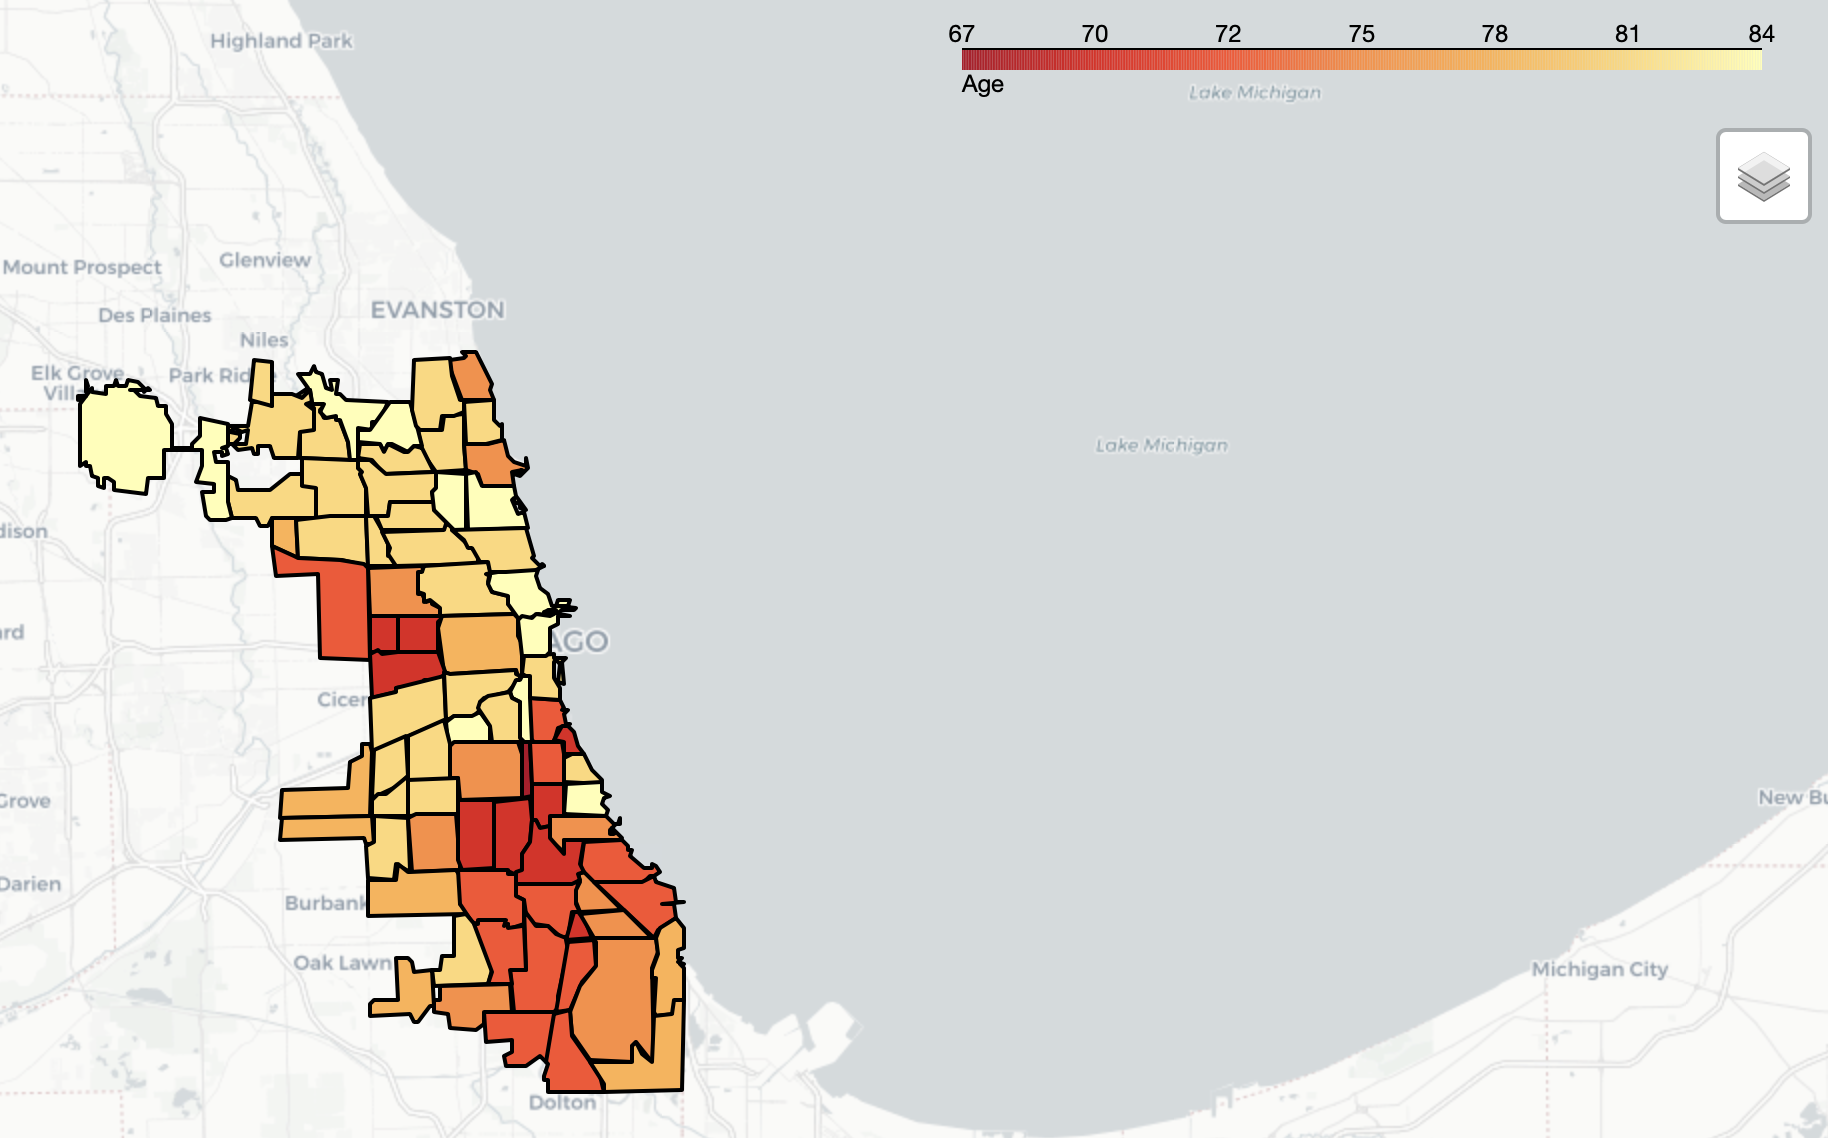

In [108]:
Image(filename='image/life_expect.png')

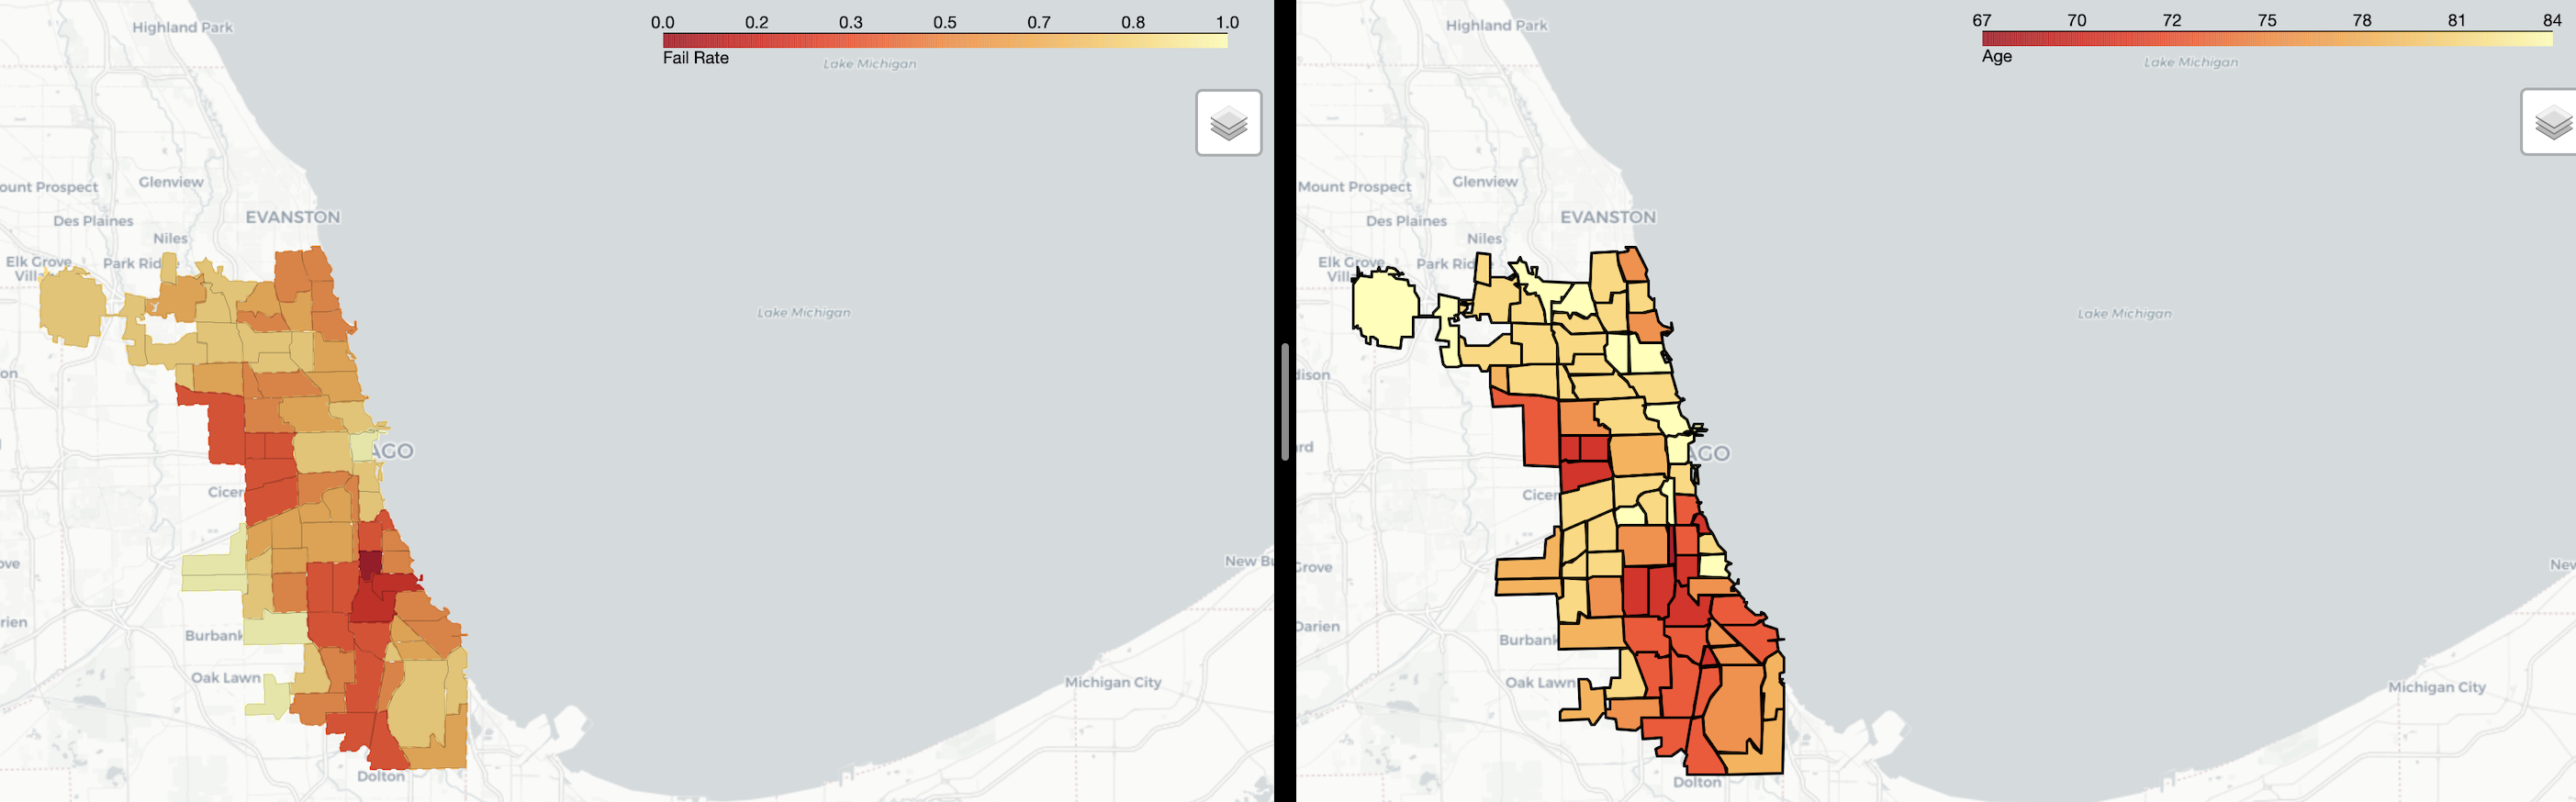

In [109]:
Image(filename='image/failVSlife.png')

**Left image is fail rate and Right image is the life expectancy**  
We observe that the distributions of fail rate and life expectancy over communities are highly correlated. Additionally, the table below shows the average fail rate and life expectancy of the North, the Downtown and the South. 

In [116]:
life_mean = [chicago_life_expectancy.loc[chicago_life_expectancy.index.isin(x)].average.mean() for x in [north, center, south]]
fail_mean = [Community_rate.loc[Community_rate.Community.isin(x)].fail.mean() for x in [north, center, south]]
fail_life_expectancy = pd.DataFrame(list(zip(fail_mean, life_mean)), index = ['north', 'center', 'south'],\
                       columns =['fail_mean', 'life_expect_mean'])
fail_life_expectancy

fail_mean  life_expect_mean
north    0.219249         79.922509
center   0.232691         76.529378
south    0.235911         75.853534

**Observation**
1. North: Food establishments are in general cleaner and these communities have a higher life expectancy. 
2. South: Food establishments are in general dirtier and these communities have a lower life expectancy.
3. Downtown: There is a mix between high and low QOL communities in the Downtown. However, life expectancy and fail rate are still highly correlated. For example, North Lawndale has relatively higher fail rate and lower life expectancy, while Loop has relatively lower fail rate and higher life expectancy.

## 3.2. Chicago Crime Dataset<a name="crime"></a>

### Data Cleaning
Here we use the `Chicago Crime Dataset` to find possible relationship between the food inspection results in a specific area and the number of crimes in that area. Therefore, we only care about the time and location of a specific crime record, and hence we only use a subset of the columns in `Chicago Crime Dataset`: **ID**(its primary key), **Year**, **Block**, **Community Area**, **Latitude**, **Longitude**.

The **Community Area** column indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6. In order to find out the exact community name of the crime, we join it with a secondary dataset `Common Area in Chicago`.

In [118]:
CRIME_DATA_PATH = 'data_raw/crimes.csv'

In [119]:
crime_raw = pd.read_csv(CRIME_DATA_PATH, low_memory=False)
crime_raw = crime_raw[['ID', 'Year', 'Community Area', 'Block', 'Latitude', 'Longitude']]
crime_raw.head()

ID  Year  Community Area                 Block  Latitude  Longitude
0  11034701  2001            45.0       016XX E 86TH PL       NaN        NaN
1  11227287  2017            73.0    092XX S RACINE AVE       NaN        NaN
2  11227583  2017            70.0       026XX W 79TH ST       NaN        NaN
3  11227293  2017            42.0  060XX S EBERHART AVE       NaN        NaN
4  11227634  2017            32.0   001XX W RANDOLPH ST       NaN        NaN

**we retain the crime records between 2010-2019**

In [120]:
year = [i for i in range(2010, 2020)]
crime_raw = crime_raw.loc[crime_raw.Year.isin(year)]
print("Year : ", crime_raw.Year.unique())

Year :  [2017 2013 2015 2012 2014 2011 2010 2016 2018 2019]


In [121]:
print("Fraction of NaNs in each column: ")
crime_raw.isnull().sum()/len(crime_raw) * 100

Fraction of NaNs in each column: 


ID                0.000000
Year              0.000000
Community Area    0.013641
Block             0.000000
Latitude          0.727154
Longitude         0.727154
dtype: float64

We decide to drop the nulls.

In [122]:
crime_raw = crime_raw.dropna()

**Add community information to crime dataframe**

In [123]:
crime_raw = crime_raw.merge(community_info[['AREA_NUMBE', 'COMMUNITY']], left_on = 'Community Area', right_on = 'AREA_NUMBE')
crime_raw.head(3)

ID  Year  Community Area                Block   Latitude  Longitude  \
0  11556037  2019            76.0      0000X W RWY 27R  42.002816 -87.906094   
1  11702339  2019            76.0  0000X W TERMINAL ST  41.976763 -87.900984   
2  11712371  2019            76.0  0000X W TERMINAL ST  41.979006 -87.906463   

   AREA_NUMBE COMMUNITY  
0          76     OHARE  
1          76     OHARE  
2          76     OHARE

**We caculate the number of crime for each Community**

In [124]:
crime_per_community = crime_raw.groupby(['COMMUNITY'])\
                   .count()[['ID']]\
                   .rename(columns={"ID": "#crime"})
crime_per_community.reset_index(inplace= True)
crime_per_community.head()

COMMUNITY  #crime
0     ALBANY PARK   26408
1  ARCHER HEIGHTS   10319
2   ARMOUR SQUARE   11841
3         ASHBURN   26676
4  AUBURN GRESHAM   83821

In [125]:
with open('data_cleaned/data.pkl', 'rb') as f:
    data = pickle.load(f)
data = data.merge(crime_per_community, left_on='Community', right_on='COMMUNITY')
data.head(3)

Community                                           geometry  region  \
0      DOUGLAS  POLYGON ((-87.60914 41.84469, -87.60915 41.844...       2   
1      OAKLAND  POLYGON ((-87.59215 41.81693, -87.59231 41.816...       2   
2  FULLER PARK  POLYGON ((-87.62880 41.80189, -87.62879 41.801...       2   

   where    COMMUNITY  #crime  
0  South      DOUGLAS   26509  
1  South      OAKLAND    6972  
2  South  FULLER PARK    9918

In [126]:
max_fail = data['#crime'].sort_values().values[-2]
min_fail = data['#crime'].min()
fail_1 = ((max_fail-min_fail)/6)+min_fail
fail_2 = (2*(max_fail-min_fail)/6) +min_fail
fail_3 = (3*(max_fail-min_fail)/6) +min_fail
fail_4 = (4*(max_fail-min_fail)/6) +min_fail
fail_5 = (5*(max_fail-min_fail)/6) +min_fail


def my_color_function(feature):
    """Maps low values to green and hugh values to red."""
    community_name = feature['properties']['community']
    if(data[data['Community'] ==community_name]['#crime'].iloc[0] == data['#crime'].sort_values().values[-1]):
        return  '#B10026'
    elif(data[data['Community'] ==community_name]['#crime'].iloc[0] <= fail_1):
        return  '#FFFFB2'
    elif(data[data['Community'] ==community_name]['#crime'].iloc[0] <= fail_2):
        return  '#FED976'
    elif(data[data['Community'] ==community_name]['#crime'].iloc[0] <= fail_3):
        return  '#FEB24C' 
    elif(data[data['Community'] ==community_name]['#crime'].iloc[0] <= fail_4):
        return  '#FD8D3C'
    elif(data[data['Community'] ==community_name]['#crime'].iloc[0] <= fail_5):
        return  '#FC4E2A'
    else:
        return '#E31A1C' 
    
m = folium.Map(location=[chicago['Latitude'].mean()-0.04, chicago['Longitude'].mean()], zoom_start=10)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)


folium.GeoJson(
    geo_comm,
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'fillOpacity': 1, 
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(m)

import branca.colormap as cm
colormap = cm.linear.YlOrRd_09.scale(min_fail,max_fail)
colormap.caption = 'Average Crime Number'
colormap.add_to(m)

folium.LayerControl().add_to(m)
m.save("image/crime.html")

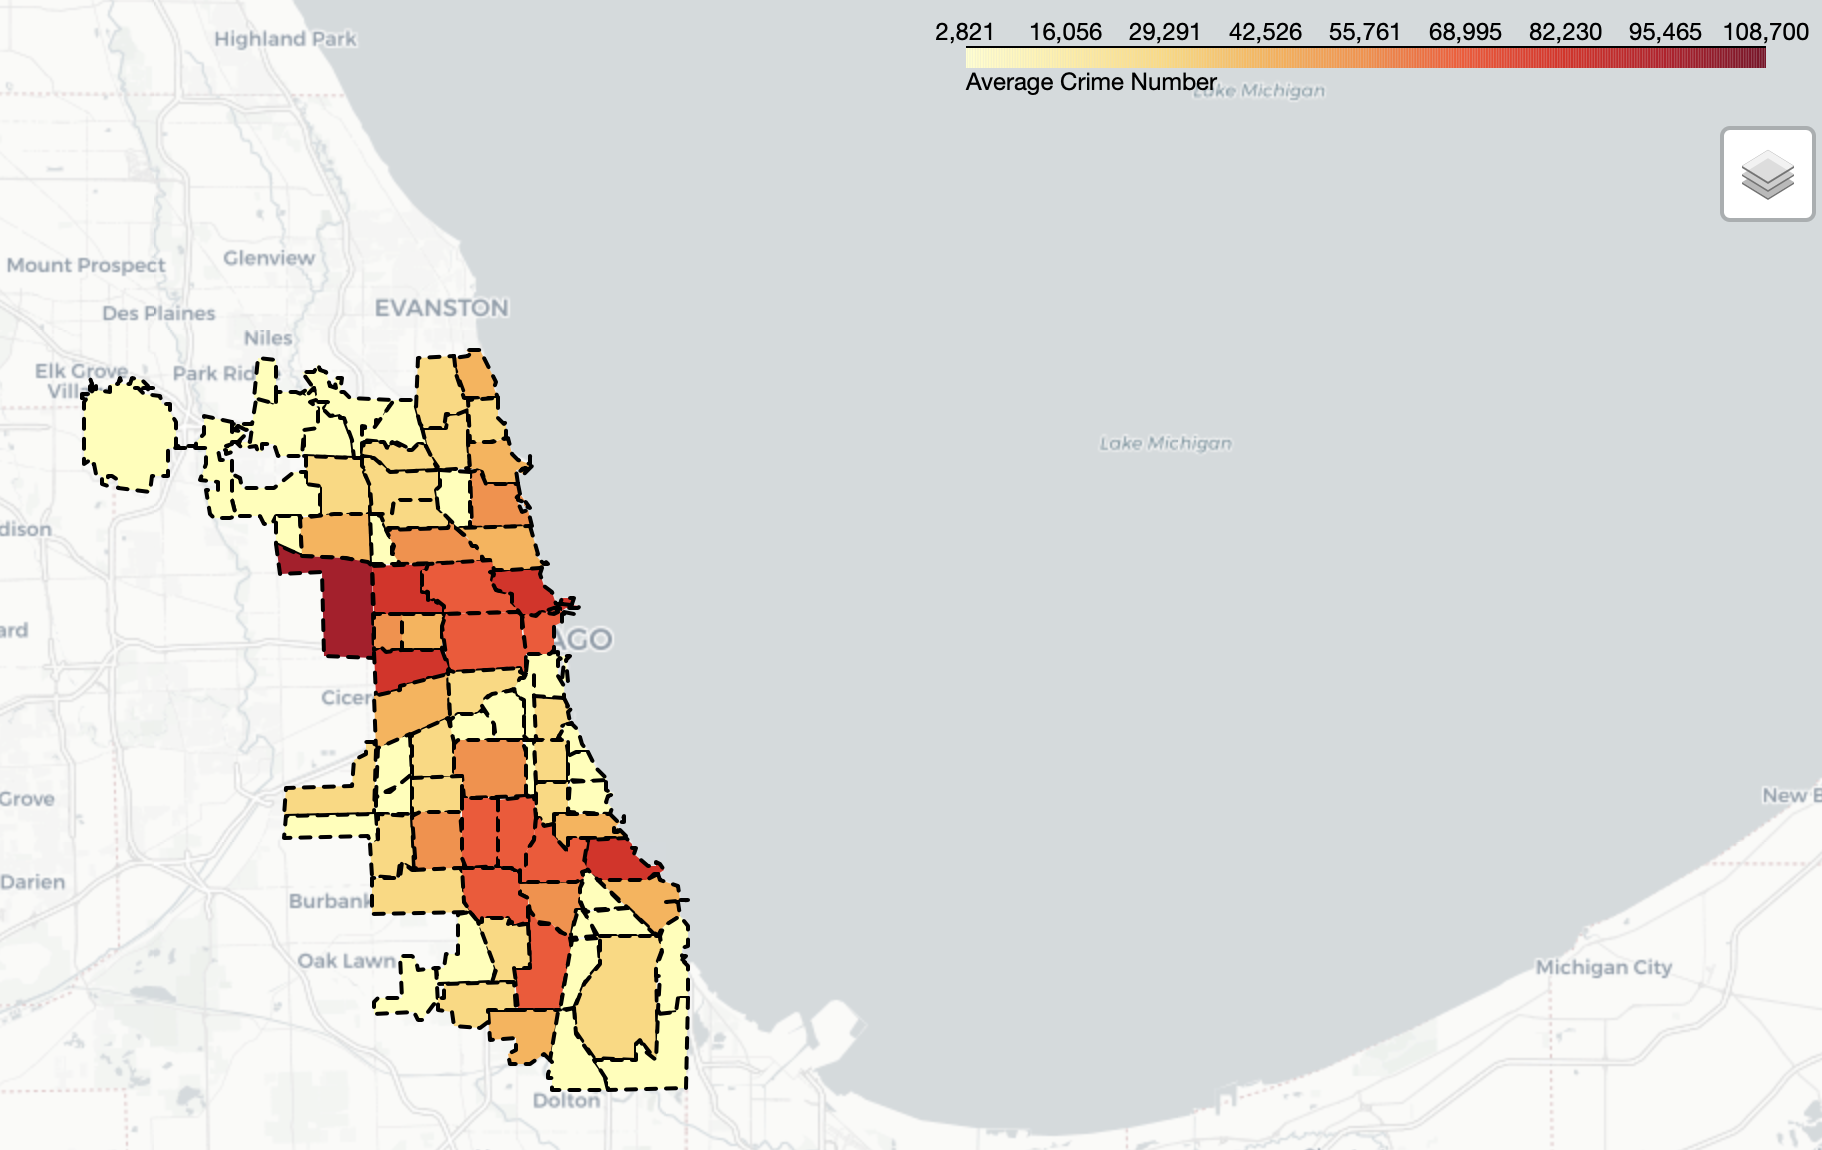

In [127]:
Image(filename='image/crime.png')

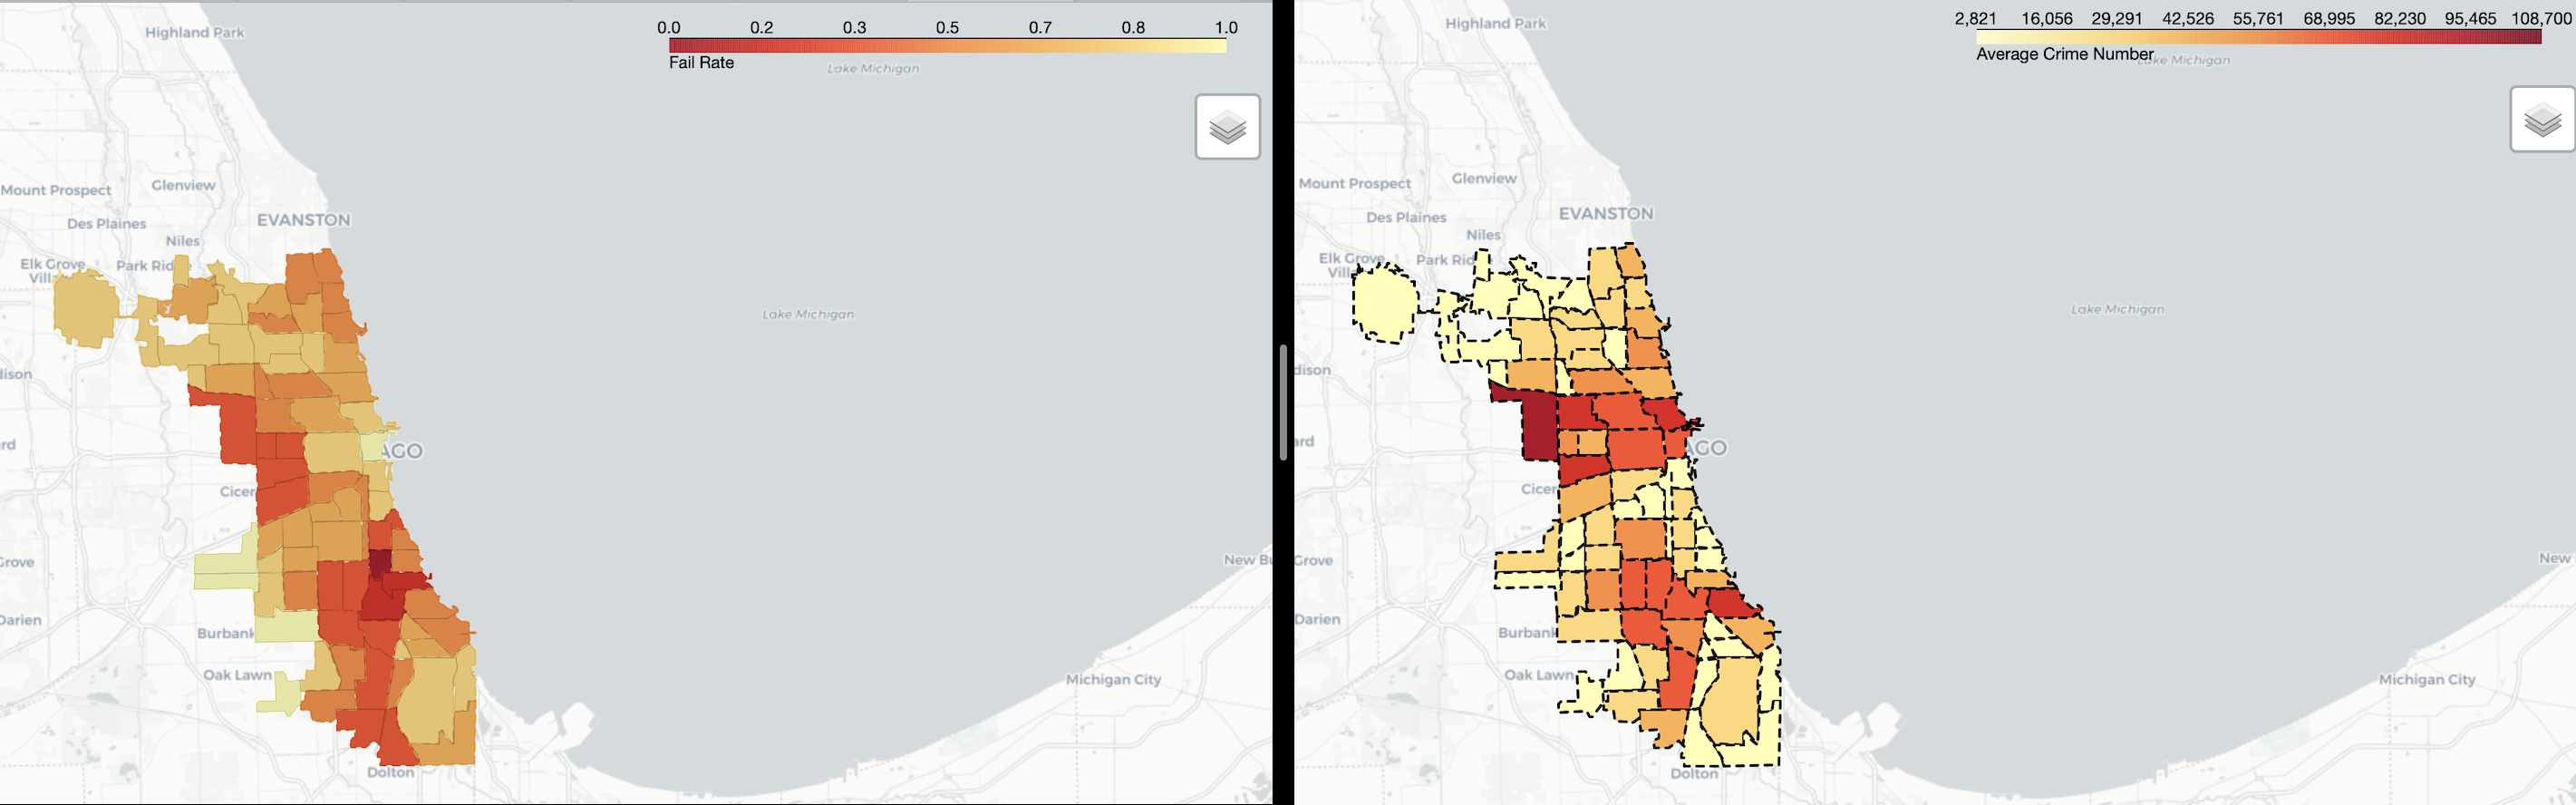

In [128]:
Image(filename='image/failVScrime.png')

We observe that the patterns of crime and fail rate over communities are highly correlated. Additionally, the table below shows the number of crimes and fail rate of the North, the Downtown and the South. 

In [97]:
north.remove('AUSTIN')
crime_mean = [crime_per_community.loc[crime_per_community.COMMUNITY.isin(x)]['#crime'].mean() for x in [north, center, south]]
fail_mean = [Community_rate.loc[Community_rate.Community.isin(x)].fail.mean() for x in [north, center, south]]
fail_crime = pd.DataFrame(list(zip(fail_mean, crime_mean)), index = ['north', 'center', 'south'],\
                       columns =['fail_mean', 'crime_mean'])
fail_crime

fail_mean    crime_mean
north    0.216963  27269.652174
center   0.232691  83492.375000
south    0.235911  32123.355556

**Observation**
1. North: These communities are the safest (lowest crimes) and also the cleanest.
2. South: There are more crimes and also poorer hygiene situation. 
3. Downtown: Most dangerous communities (highest crimes), relatively lower. Although the restaurants in the downtown area are in good health, the crime rate is high due to the high mobility of people.


# 4. Yelp<a name="Yelp"></a>

We searched for the restaurants, bars, cafes and etc. that can be shown on Yelp.com and scrped the data.

In [129]:
YELP_DATA_PATH = 'data_raw/yelp.csv'

In [130]:
yelp_raw = pd.read_csv(YELP_DATA_PATH)
yelp_raw.head()

business_name  review_count  \
0     kuma's corner - belmont          5000   
1                     hopleaf          2077   
2  honey butter fried chicken          1874   
3                     m.henry          1692   
4                   big jones          1479   

                                          categories  rating  \
0                                       pubs,burgers     4.0   
1                                        gastro pubs     4.0   
2  chicken shop,takeaway & fast food,breakfast & ...     4.0   
3            breakfast & brunch,american (new),cafes     4.0   
4                   southern,breakfast & brunch,bars     4.0   

                         address price_range  \
0    2900 w belmont ave avondale          $$   
1  5148 n clark st andersonville          $$   
2     3361 n elston ave avondale          $$   
3  5707 n clark st andersonville          $$   
4  5347 n clark st andersonville          $$   

                                                 url  
0  https://www.yelp.com/biz/kumas-corner-belmont-...  
1  https://www.yelp.com/biz/hopleaf-chicago?osq=R...  
2  https://www.yelp.com/biz/honey-butter-fried-ch...  
3  https://www.yelp.com/biz/m-henry-chicago?osq=R...  
4  https://www.yelp.com/biz/big-jones-chicago?osq...

## 4.1. Data Cleaning<a name="Yelp_data_cleaning"></a>
### 4.1.1. Check duplicates

We checked that there are no duplicated rows in the dataset. 
However, there might be a situation that the same restaurant is scarped under different search filter and hence there is a difference in the field "url", or the same restaurant's review/rating has changed during the scraping. Therefore, we check for them here.

As below, there are indeed duplicates in the Yelp dataset.

In [132]:
yelp_raw[yelp_raw.duplicated(subset = ['business_name','address'], keep = False)].sort_values(by = 'business_name').head()

business_name  review_count  \
4945   1492 cuban fusion           163   
5848   1492 cuban fusion           163   
2226  1959 kitchen & bar            79   
6209  1959 kitchen & bar            79   
7642  1959 kitchen & bar            80   

                                            categories  rating  \
4945                                             cuban     4.5   
5848                                             cuban     4.5   
2226   american (traditional),gastropubs,cocktail bars     4.0   
6209  american (traditional),gastro pubs,cocktail bars     4.0   
7642  american (traditional),gastro pubs,cocktail bars     4.0   

                            address price_range  \
4945  2615 west north ave west town           $   
5848  2615 west north ave west town           $   
2226   230 w north ave lincoln park          $$   
6209   230 w north ave lincoln park          $$   
7642   230 w north ave lincoln park          $$   

                                                    url  
4945  https://www.yelp.com/biz/1492-cuban-fusion-chi...  
5848  https://www.yelp.com/biz/1492-cuban-fusion-chi...  
2226  https://www.yelp.com/biz/1959-kitchen-and-bar-...  
6209  https://www.yelp.com/biz/1959-kitchen-and-bar-...  
7642  https://www.yelp.com/biz/1959-kitchen-and-bar-...

We identify a restaurant with the same name and at the same address as the same restaurant. After dropping these duplicates, each restaurant is unique now and therefore we give each restaurant a primary key called "pk" to uniquely distinguish each restaurant. 

In [133]:
print('The number of restaurants before dropping duplicates: ', len(yelp_raw))
print('The number of restaurants after dropping duplicates: ', len(yelp_raw.drop_duplicates(subset = ['business_name','address'])))

The number of restaurants before dropping duplicates:  8111
The number of restaurants after dropping duplicates:  7169


In [134]:
yelp_raw.drop_duplicates(subset = ['business_name','address'], inplace = True)

In [135]:
yelp_raw = yelp_raw.reset_index().rename(columns={'index':'pk'})
yelp_raw.head()

pk               business_name  review_count  \
0   0     kuma's corner - belmont          5000   
1   1                     hopleaf          2077   
2   2  honey butter fried chicken          1874   
3   3                     m.henry          1692   
4   4                   big jones          1479   

                                          categories  rating  \
0                                       pubs,burgers     4.0   
1                                        gastro pubs     4.0   
2  chicken shop,takeaway & fast food,breakfast & ...     4.0   
3            breakfast & brunch,american (new),cafes     4.0   
4                   southern,breakfast & brunch,bars     4.0   

                         address price_range  \
0    2900 w belmont ave avondale          $$   
1  5148 n clark st andersonville          $$   
2     3361 n elston ave avondale          $$   
3  5707 n clark st andersonville          $$   
4  5347 n clark st andersonville          $$   

                                                 url  
0  https://www.yelp.com/biz/kumas-corner-belmont-...  
1  https://www.yelp.com/biz/hopleaf-chicago?osq=R...  
2  https://www.yelp.com/biz/honey-butter-fried-ch...  
3  https://www.yelp.com/biz/m-henry-chicago?osq=R...  
4  https://www.yelp.com/biz/big-jones-chicago?osq...

### 4.1.2. Check NaNs
Only the column "price_range" has null values. 

In [136]:
yelp_raw.isnull().sum()

pk                  0
business_name       0
review_count        0
categories          0
rating              0
address             0
price_range      2088
url                 0
dtype: int64

### 4.1.3. Tag Cleaning for Column "Categories"
The column categories describes a few tags that apply to the restaurant. It can be the type of the restaurant, its specialty dishes, cuisine type and etc. One restaurant can have multiple tags. 

However, not all tags are popular. Below we explode the tags and count the occurences of each tag and we find out that the tags generally follows a heavy-tail ditribution. 

In [137]:
yelp_raw['categories'] = yelp_raw['categories'].str.split(',')

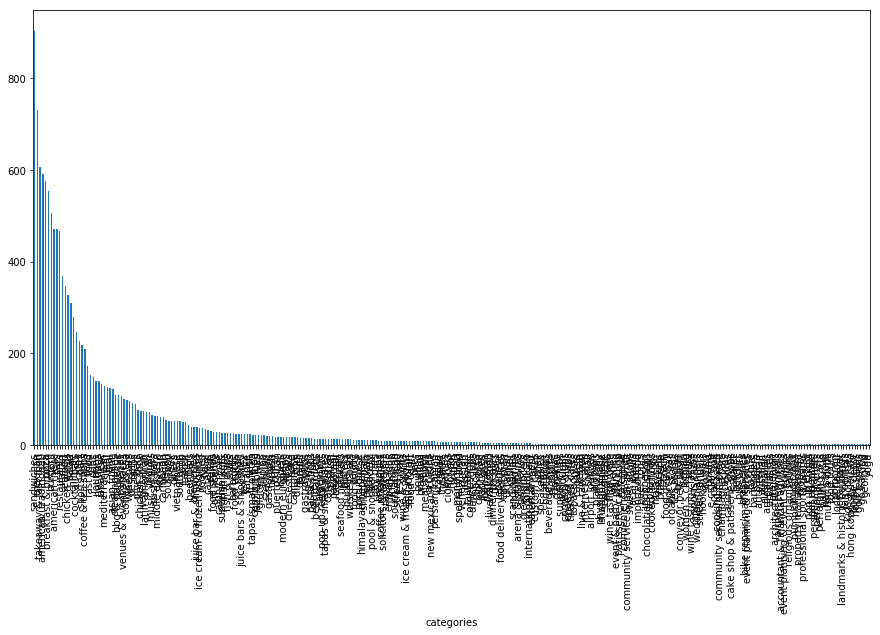

In [138]:
yelp_raw.explode('categories').groupby('categories').count().sort_values(by = 'pk', ascending = False)['pk']\
    .plot(kind = 'bar', figsize = (15, 8))

Our **aim** of tag-cleaning is to find popular tags and observe the food inspection hygiene pattern associtated with the tag, and hence we do not focus on all the tags as some of them will only appear few times. 


**a. Find All Tags**\
We find out the set of all tags appeared in the dataset.

In [139]:
categories_set = set()
for l in yelp_raw['categories'].values.tolist():
    for ele in l:
        categories_set.add(ele)
print('The total number of tags: ', len(categories_set))

The total number of tags:  299


**b. Cluster several tags into one tag**\
We found that the tags can be very disordered and somtimes too specific, for example except `bars`, there are also tags such as `beer bars`, `wine bars`, `wine & spirits` and etc. There fore, we decide to cluster such tags into one single tag for cleaning.\
Below we use a simiple string clustering algorithm based on affinity propogation to facilitate further manual accumulation of the tags. 

In [141]:
import numpy as np
import sklearn.cluster
import distance

words = np.asarray(list(categories_set)) 
lev_similarity = -1*np.array([[distance.jaccard(w1,w2) for w1 in words] for w2 in words])

affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print("**%s** -- %s" % (exemplar, cluster_str))

**food courts** -- comfort food, food court, food courts, food tours, food trucks, soul food, street food
**casinos** -- acai bowls, asian fusion, casinos, dominican, indonesian, moroccan, scandinavian, scottish, sicilian, tobacconists
**austrian** -- australian, austrian, restaurants, russian, sushi, turkish, ukranian
**dance clubs** -- beer gardens, bocce ball, bubble tea, comedy clubs, cuban, dance clubs, jazz & blues, supper clubs
**hawaiian** -- afghan, hawaiian, thai
**pan asian** -- nail salons, paint & sip, pakistani, pan asian, piano bars, pizza, spanish
**music & dvds** -- dim sum, music & dvds, music venues
**pasta shops** -- hobby shops, hot dogs, hot pot, meat shops, pasta shops, pool halls, pop up shops, sweet shops
**buffet** -- buffet, buffets, uzbek
**airport terminals** -- airport lounges, airport terminals, american (traditional), arena & stadiums, himalayan/nepalese, imported food, middle eastern, performing arts, personal trainers, professional sports teams, proper

Then we manually aggregate similar tags into one single tag.

In [142]:
reduce_dict = {
'asian':  ['asian fusion', 'paint & sip', 'pan asian' ],
'bars' : ['piano bars', 'music & dvd', 'music & dvds', 'music venues', 'champagne bars','nightlife', 'brewpubs', 'clubs', 'pubs','speakeasies', 'bars', 'bartenders', 'beer', 'beer bar', 'beer bars', 'brasserie', 'brasseries', 'wine bars', 'wineries', ' wine & spirits', 'breweries', 'beer tours', 'sports clubs', 'tours', 'cocktail bars', 'cigar bars', 'gay bars', 'hookah bars',  'beverage stores', 'gastro pubs', 'gastropubs', 'sports bars', 'dance clubs', 'jazz & blues', 'supper clubs', 'musicians', 'cabaret', 'cabarets', 'wine tasting room', 'wine tasting classes', 'distilleries', 'dive bars', 'tiki bars', 'whiskey bars', 'comedy clubs', 'beer gardens',  'shisha bars', 'pumpkin patches','bocce ball'],

'spanish' : ['spanish', 'tapas bars', 'empanadas', 'tapas & small plates' , 'tapas/small plates'],
'italian' : ['pizza' , 'pasta shops','gelato'],
'mexican' : ['tacos','tex-mex', 'mexican', 'new mexican cuisine' , 'salvadoran' ],
'cafes' :  ['cafes','desserts', 'cafeteria', 'cafeterias','ice cream & frozen yoghurt', 'coffee roasteries', 'creperies', 'festivals', 'internet cafes', 'coffee & tea shops', 'juice bar & smoothies', 'juice bars & smoothies', 'ice cream & frozen yogurt', 'coffee & tea', 'themed cafes', 'waffles' , 'breakfast & brunch', 'custom cakes', 'shaved ice', 'cupcakes', 'pancakes', 'bakeries', 'tea rooms', 'cheesesteaks', 'crepes','cake shop & patisserie shops', 'chocolatiers & shops', 'patisserie/cake shop' ],

'chinese' : ['chinese', 'shanghainese', 'dim sum', 'szechuan', 'taiwanese', 'hot pot', 'cantonese', 'bubble tea', 'hong kong style cafe', 'noodles' ],
'japanese' : ['izakaya', 'ramen', 'teppanyaki', 'sushi', 'sushi bars', 'conveyor belt sushi', 'poke' ],
'british' : ['british', 'fish & chips' ],
'takeaway & fast food' : ['takeaway & fast food','delis', 'fast food', 'food', 'food stands', 'food delivery', 'food delivery services', 'pop-up restaurants', 'sandwiches', 'cheese shops', 'chicken shop', 'corner shops' ],

'american' : ['american (traditional)', 'american (new)','southern' , 'cajun/creole', 'georgian', 'burgers'], 
'irish' : ['irish pub', 'irish pubs'], 
np.nan: ['acai bowls', 'soup', 'tobacconists', 'hot dogs', 'nail salons', 'salad', 'bagels', 'basque', 'casinos',  'fondue', 'pretzels', 'salad', 'restaurants', 'auto repair', 'bike repair/maintenance', 'property', 'community service & non profit', 'community service/non-profit', 'accountant & financial advisors', 'kids activities', 'gluten free', 'gluten-free', 'cookery schools', 'home decor', 'personal chefs', 'landmarks & historic buildings', 'golf', 'golf lessons', 'lounges',  'off licence', 'live & raw food', 'live/raw food', 'airport lounges', 'airport terminals',  'arena & stadiums',  'hobby shops', 'crazy golf', 'local flavor', 'local flavour', 'dinner theater', 'eatertainment','barbers',  'pet adoption', 'diners',   'physiotherapy', 'pool & snooker hall', 'solicitors & lawyers', 'specialty food', 'vegan', 'vegetarian', 'boat tours', 'bus tours', 'architectural tours','comfort food', 'food court', 'food courts', 'food tours', 'food trucks', 'soul food', 'street food', 'butcher', 'butchers','event & party planning', 'event planning & event services', 'event planning & services', 'venues & event spaces', 'wedding planners', 'barbeque', 'bbq & barbecue', 'buffet', 'buffets', 'arcades', 'art classes',  'caterers','karaoke', 'hotels',  'steakhouses', 'street vendors', 'art galleries', 'candy stores',  'chicken wings', 'convenience stores', 'cooking classes', 'e cigarette',  'go karting', 'greengrocers', 'grocery', 'international grocery', 'organic stores', 'religious organisations','bowling', 'boxing',  'yoga', 'women\'s clothing', 'donuts', 'kosher', 'modern european', 'imported food',  'performing arts', 'personal trainers', 'professional sports teams', 'property management', 'supermarkets', 'meat shops', 'pool halls', 'pop up shops', 'sweet shops', 'lan centers', 'markets', 'theatres'],

'middle eastern': ['falafel', 'halal','kebab', 'wraps', 'cinemas' ],
'seafood' : ['seafood', 'seafood markets'  ],
'latin american': ['puerto rican' ]
}

In [143]:
replace_map = {}; i = 0
for center in reduce_dict:
    for ele in reduce_dict[center]:
        replace_map[ele] = center
        if i < 5:
            print('Example: Replace the tags \'{}\' with \'{}\' '.format(ele, center))
        i += 1

Example: Replace the tags 'asian fusion' with 'asian' 
Example: Replace the tags 'paint & sip' with 'asian' 
Example: Replace the tags 'pan asian' with 'asian' 
Example: Replace the tags 'piano bars' with 'bars' 
Example: Replace the tags 'music & dvd' with 'bars' 


**c. Replace tags**

In [144]:
yelp_exploded = yelp_raw.copy()

#split and explode the category tags
yelp_exploded = yelp_exploded.explode('categories')

# reduce the tags such that rare tags are accumulated to common tags for convenience of analysis
yelp_exploded[['categories']] = yelp_exploded[['categories']].replace(replace_map)#.reset_index(drop = True)#.drop_duplicates()
yelp_exploded.drop_duplicates(inplace = True)
yelp_exploded.reset_index(drop = True)

# remove the tags we do not care
yelp_exploded.dropna(subset = ['categories'], inplace = True)

yelp_exploded.head()

pk               business_name  review_count            categories  rating  \
0   0     kuma's corner - belmont          5000                  bars     4.0   
0   0     kuma's corner - belmont          5000              american     4.0   
1   1                     hopleaf          2077                  bars     4.0   
2   2  honey butter fried chicken          1874  takeaway & fast food     4.0   
2   2  honey butter fried chicken          1874                 cafes     4.0   

                         address price_range  \
0    2900 w belmont ave avondale          $$   
0    2900 w belmont ave avondale          $$   
1  5148 n clark st andersonville          $$   
2     3361 n elston ave avondale          $$   
2     3361 n elston ave avondale          $$   

                                                 url  
0  https://www.yelp.com/biz/kumas-corner-belmont-...  
0  https://www.yelp.com/biz/kumas-corner-belmont-...  
1  https://www.yelp.com/biz/hopleaf-chicago?osq=R...  
2  https://www.yelp.com/biz/honey-butter-fried-ch...  
2  https://www.yelp.com/biz/honey-butter-fried-ch...

Here we show **all tags** after tag-cleaning. 

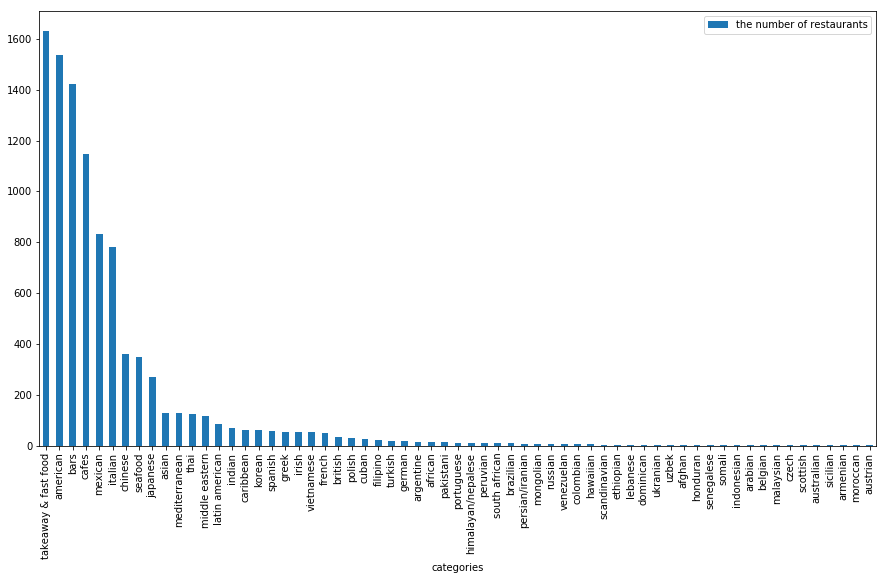

In [145]:
yelp_exploded.groupby('categories').count().sort_values(by = 'pk', ascending = False)[['pk']]\
    .rename(columns={"pk": "the number of restaurants"}).plot(kind = 'bar', figsize = (15, 8))

In [146]:
print('The set of tags after cleaning are: \n', \
      yelp_exploded.groupby('categories').count().sort_values(by = 'pk', ascending = False).index.tolist())

The set of tags after cleaning are: 
 ['takeaway & fast food', 'american', 'bars', 'cafes', 'mexican', 'italian', 'chinese', 'seafood', 'japanese', 'asian', 'mediterranean', 'thai', 'middle eastern', 'latin american', 'indian', 'caribbean', 'korean', 'spanish', 'greek', 'irish', 'vietnamese', 'french', 'british', 'polish', 'cuban', 'filipino', 'turkish', 'german', 'argentine', 'african', 'pakistani', 'portuguese', 'himalayan/nepalese', 'peruvian', 'south african', 'brazilian', 'persian/iranian', 'mongolian', 'russian', 'venezuelan', 'colombian', 'hawaiian', 'scandinavian', 'ethiopian', 'lebanese', 'dominican', 'ukranian', 'uzbek', 'afghan', 'honduran', 'senegalese', 'somali', 'indonesian', 'arabian', 'belgian', 'malaysian', 'czech', 'scottish', 'australian', 'sicilian', 'armenian', 'moroccan', 'austrian']


Below we collect the exploded tags back to a string for future analysis.

In [147]:
yelp_cleaned = yelp_raw.merge(\
        yelp_exploded.groupby('pk')['categories'].apply(list).to_frame().rename(columns = {'categories':'tags'}),\
        on = 'pk')

yelp_cleaned['tags'] = yelp_cleaned['tags'].apply(','.join)
yelp_cleaned['categories'] = yelp_cleaned['categories'].apply(','.join)
yelp_cleaned.head()

pk               business_name  review_count  \
0   0     kuma's corner - belmont          5000   
1   1                     hopleaf          2077   
2   2  honey butter fried chicken          1874   
3   3                     m.henry          1692   
4   4                   big jones          1479   

                                          categories  rating  \
0                                       pubs,burgers     4.0   
1                                        gastro pubs     4.0   
2  chicken shop,takeaway & fast food,breakfast & ...     4.0   
3            breakfast & brunch,american (new),cafes     4.0   
4                   southern,breakfast & brunch,bars     4.0   

                         address price_range  \
0    2900 w belmont ave avondale          $$   
1  5148 n clark st andersonville          $$   
2     3361 n elston ave avondale          $$   
3  5707 n clark st andersonville          $$   
4  5347 n clark st andersonville          $$   

                                                 url  \
0  https://www.yelp.com/biz/kumas-corner-belmont-...   
1  https://www.yelp.com/biz/hopleaf-chicago?osq=R...   
2  https://www.yelp.com/biz/honey-butter-fried-ch...   
3  https://www.yelp.com/biz/m-henry-chicago?osq=R...   
4  https://www.yelp.com/biz/big-jones-chicago?osq...   

                         tags  
0               bars,american  
1                        bars  
2  takeaway & fast food,cafes  
3              cafes,american  
4         american,cafes,bars

# 4.2. Sim-Join Chicago with Yelp<a name="sim_join"></a>

As a common sense in daily life, a restaurant can be uniquely identifies by its **name** and its **address**. No two independent restaurants would share the same name if they are at the same address. 

With this heuristic, we join the cleaned Yelp dataset with the cleaned Chicago dataset based on restaurant names and addresses. However, this can be tricky as there are mainly two **problems**:
1. The **naming** of a restaurant can be a bit different under the two datasets. For example: "the kitchen chicago" and "the kitchen" are actaully the same restaurant.
2. The same restaurant may have different **addresses** under Yelp and Chicago Food Inspection. For example, "3867 archer ave brighton park" and "3867 archer ave" both corresponds to a McDonald. 

In order to perform a **similarity join**, we do **three steps**:

1. Add a new column called "Sim Name" in the Chicago dataset to show its most possible name in the Yelp dataset.
2. Equi-join the Chicago dataset and the Yelp dataset by "Sim Name" and "business_name".
3. Compare "Address" in Chicago and "address" in Yelp to filter out the restaurants that are matched incorrectly.

Below we show the details of this sim-join implementation.

### Step 1. For Chicago: find its most possible name match in Yelp

In order to reduce the time complexity, we find the list of all the restaurants in stead of inspections in the Chicago datset. And we add a new column called "Sim Name" in the `chicago_restaurant` dataframe to show its most possible name in the Yelp dataset.

In [691]:
chicago_restaurants = chicago[['DBA Name', 'AKA Name', 'License #', 'Address', 'Zip']].drop_duplicates()
chicago_restaurants.shape#[chicago_restaurants['AKA Name'] == 'jerk modern jamaican grill']

(38673, 5)

We collect all the restaurant names in the Yelp dataset into a set and then use this set to probe each restaurant's name in Chicago dataset. 

Here we use the **Jaccard similarity** as a measure of similarity between the names. The **best match** in the Yelp name set will be selected and utilized.
Additionally, when comparing two names, we do some very simple **preprocessing**, such as a stop-word list containing simple sords that we found influence the similarity metrics when experimenting on the implementation.


In [692]:
def get_closest_match(x, list_strings):
    '''
    This function is used in pd.Series.apply() and finds the closest name match with the yelp dataset that is above
    a threshold.
    
    Args:
        x: a cell in pd.Series
        list_strings: the probe list that is used to find the closest match
        
    Returns:
        the closest name match if found and np.nan otherwise
    '''
    best_match = None
    highest_sim = 0

    for current_string in list_strings:
        if current_string == x:
            return (current_string, 1.0)
        
        current_score = jaccard_similarity(x, current_string)

        if(current_score > highest_sim):
            highest_sim = current_score
            best_match = current_string
            
    if highest_sim >= 0.3:
        return (best_match, highest_sim)
    else:
        return np.nan
    
    
def jaccard_similarity(string_A, string_B):
    '''
    Calculates the Jaccard similartiy between two strings
    
    Args: 
        string_A: a string
        string_B: a string
        
    Returns:
        the Jaccard similarity
    '''
    string_A = string_A.split(); A = []
    string_B = string_B.split(); B = []
    stop_words = set(['the', 'restaurant', 'and', 'food', 'foods', \
                      'pizzeria'])
    
    # "#" indicates a branch of a chain, so we don't care this "#" word
    for word in string_A:
        if not word.startswith('#') and word not in stop_words: 
            A.append(word.replace('\'', ''))
    
    for word in string_B:
        if not word.startswith('#') and word not in stop_words: 
            B.append(word.replace('\'', ''))
    
    intersection = set(A).intersection(set(B))
    union = set(A).union(set(B))
    return len(intersection)/len(union)

In [159]:
yelp_rest_name_set = set(yelp_cleaned['business_name'].values.tolist())

In [693]:
chicago_restaurants['Sim Name'] = chicago_restaurants['AKA Name']\
                        .apply(lambda x: get_closest_match(x, yelp_rest_name_set))

This step to find the most similar restaurant name can be very slow. Therefore, we saved this dataframe in a pickle

In [25]:
with open('pickle/chicago_restaurant_sim_name', 'rb') as f:
    chicago_restaurants = pickle.load(f)

In [26]:
chicago_restaurants[chicago_restaurants['DBA Name'] == 'frasca']

DBA Name AKA Name  License #               Address    Zip  \
14616   frasca   frasca  1676691.0  3356-3358 n paulina   60657   

                                                Sim Name  
14616  (frasca pizzeria and wine bar, 0.3333333333333...

In [27]:
chicago_restaurants = chicago_restaurants.dropna(subset = ['Sim Name'])
chicago_restaurants['Sim Name'] = chicago_restaurants['Sim Name'].apply(lambda x: x[0])
chicago_restaurants

DBA Name                      AKA Name  \
0                              subway                        subway   
1       la michoacana  ice cream shop  la michoacana ice cream shop   
2                      the crepe shop                the crepe shop   
5                           pizza hut                     pizza hut   
7                         osito's tap                   osito's tap   
...                               ...                           ...   
195255                obama food mart               obama food mart   
195280                  dunkin donuts                 dunkin donuts   
195301        safah food & liquor inc       safah food & liquor inc   
195302                rainbow grocery               rainbow grocery   
195339                      wolcott's                       troquet   

        License #                     Address    Zip  \
0       2529116.0    2620 n narragansett ave   60639   
1       2698396.0  3591-3597 n milwaukee ave   60641   
2       2699005.0            2934 n broadway   60657   
5       2476781.0         5035 n lincoln ave   60625   
7       2658134.0        2553 s ridgeway ave   60623   
...           ...                         ...    ...   
195255  2004238.0        1800 e 79th st bldg   60649   
195280  2013344.0          970 w pershing rd   60609   
195301    14103.0          7105 s racine ave   60636   
195302    61801.0             2003 w 69th st   60636   
195339  1992040.0        1834 w montrose ave   60613   

                         Sim Name  
0                          subway  
1       five faces ice cream shop  
2                  the crepe shop  
5                       pizza hut  
7                the exchange tap  
...                           ...  
195255             mart anthony's  
195280           firecakes donuts  
195301        jay's food & liquor  
195302            rainbow cuisine  
195339        troquet river north  

[22899 rows x 6 columns]

As we have found the best name match for each restaurant in `Chicago Food Inspection`, we can now join the table above with `Chicago Food Inspection` such that every inspection record has a matching restaurant name in `Yelp`.

In [28]:
chicago_with_sim = chicago.merge(chicago_restaurants[['License #', 'Sim Name']], on = 'License #')
chicago_with_sim

Inspection ID                 DBA Name                 AKA Name  \
0             2345318                   subway                   subway   
1             2321166                   subway                   subway   
2             2144892                   subway                   subway   
3             2144588                   subway                   subway   
4             2144587                   subway                   subway   
...               ...                      ...                      ...   
188941         158243            dunkin donuts            dunkin donuts   
188942          67848  safah food & liquor inc  safah food & liquor inc   
188943         164256  safah food & liquor inc  safah food & liquor inc   
188944         164255          rainbow grocery          rainbow grocery   
188945          67733                wolcott's                  troquet   

        License #  Facility Type             Risk                   Address  \
0       2529116.0      resturant    risk 1 (high)  2620 n narragansett ave    
1       2529116.0      resturant    risk 1 (high)  2620 n narragansett ave    
2       2529116.0      resturant    risk 1 (high)  2620 n narragansett ave    
3       2529116.0      resturant    risk 1 (high)  2620 n narragansett ave    
4       2529116.0      resturant    risk 1 (high)  2620 n narragansett ave    
...           ...            ...              ...                       ...   
188941  2013344.0      resturant  risk 2 (medium)        970 w pershing rd    
188942    14103.0  grocery_store     risk 3 (low)        7105 s racine ave    
188943    14103.0  grocery_store     risk 3 (low)        7105 s racine ave    
188944    61801.0  grocery_store     risk 3 (low)           2003 w 69th st    
188945  1992040.0      resturant    risk 1 (high)      1834 w montrose ave    

          Zip Inspection Date      Inspection Type             Results  \
0       60639      2019-11-08   cavass_reinpection  pass w/ conditions   
1       60639      2019-11-06               cavass                fail   
2       60639      2018-02-13   cavass_reinpection                pass   
3       60639      2018-02-06               cavass                fail   
4       60639      2018-02-06               cavass     out of business   
...       ...             ...                  ...                 ...   
188941  60609      2010-01-05              license                fail   
188942  60636      2010-01-05   cavass_reinpection                pass   
188943  60636      2010-01-05   cavass_reinpection                pass   
188944  60636      2010-01-05   cavass_reinpection                pass   
188945  60613      2010-01-04  license_reinpection                pass   

                                               Violations   Latitude  \
0       3. management, food employee and conditional e...  41.927995   
1       3. management, food employee and conditional e...  41.927995   
2                                                     NaN  41.927995   
3       16. food protected during storage, preparation...  41.927995   
4                                                     NaN  41.927995   
...                                                   ...        ...   
188941                                                NaN  41.823504   
188942  33. food and non-food contact equipment utensi...  41.764896   
188943  33. food and non-food contact equipment utensi...  41.764896   
188944  33. food and non-food contact equipment utensi...  41.768328   
188945                                                NaN  41.961606   

        Longitude           Violations Number Rule Version  \
0      -87.785752                  [3, 5, 58]          new   
1      -87.785752  [3, 5, 10, 22, 33, 57, 58]          new   
2      -87.785752                          []          old   
3      -87.785752                [16, 34, 42]          old   
4      -87.785752                          []          old   
...           ...               

### Step 2. Join Chicago with Yelp on "Sim Name"

Equi-join the Chicago dataset and the Yelp dataset by "Sim Name" and "business_name".

In [29]:
chicago_yelp_dirty = chicago_with_sim.merge(yelp_cleaned, left_on = 'Sim Name', right_on = 'business_name')
chicago_yelp_dirty.sort_values(by = 'License #')

Inspection ID                        DBA Name  \
645718        2159892     church of the three crosses   
171974        2282248              little black pearl   
171975        2282248              little black pearl   
171976        2282248              little black pearl   
171977        2282248              little black pearl   
...               ...                             ...   
736296        1296483                leon's bar-b-que   
751962        1194225  our lady mother  of the church   
751963          88764  our lady mother  of the church   
751964          70369  our lady mother  of the church   
459979          74277       kennicott park kids cafe'   

                             AKA Name  License # Facility Type  \
645718    church of the three crosses        0.0     resturant   
171974             little black pearl        0.0        school   
171975             little black pearl        0.0        school   
171976             little black pearl        0.0        school   
171977             little black pearl        0.0        school   
...                               ...        ...           ...   
736296               leon's bar-b-que  5852857.0        others   
751962  our lady mother of the church  8700606.0        others   
751963  our lady mother of the church  8700606.0        others   
751964  our lady mother of the church  8700606.0        others   
459979                 kennicott park  9999999.0        others   

                   Risk                     Address    Zip Inspection Date  \
645718  risk 2 (medium)            333 w wisconsin   60614      2018-04-11   
171974  risk 2 (medium)             1060 e 47th st   60653      2019-03-28   
171975  risk 2 (medium)             1060 e 47th st   60653      2019-03-28   
171976  risk 2 (medium)             1060 e 47th st   60653      2019-03-28   
171977  risk 2 (medium)             1060 e 47th st   60653      2019-03-28   
...                 ...                         ...    ...             ...   
736296    risk 1 (high)             1640 e 79th st   60649      2013-07-23   
751962    risk 1 (high)        8701 w lawrence ave   60656      2012-04-10   
751963    risk 1 (high)        8701 w lawrence ave   60656      2011-04-12   
751964    risk 1 (high)        8701 w lawrence ave   60656      2010-03-17   
459979    risk 1 (high)  4434 s lake park ave bldg   60653      2010-01-22   

       Inspection Type          Results  \
645718          cavass             pass   
171974          cavass             pass   
171975          cavass             pass   
171976          cavass             pass   
171977          cavass             pass   
...                ...              ...   
736296          cavass  out of business   
751962          others             pass   
751963          others             pass   
751964          others             pass   
459979          others             pass   

                                               Violations   Latitude  \
645718  38. ventilation: rooms and equipment vented as...  41.916419   
171974  55. physical facilities installed, maintained ...  41.809722   
171975  55. physical facilities installed, maintained ...  41.809722   
171976  55. physical facilities installed, maintained ...  41.809722   
171977  55. physical facilities installed, maintained ...  41.809722   
...                                                   ...        ...   
736296                                                NaN  41.751613   
751962  32. food and non-food contact surfaces properl...  41.966356   
751963  33. food and non-food contact equipment utensi...  41.966356   
751964                                                NaN  41.966356   
459979                                                NaN  41.814118   

        Longitude Violations Number Rule Version  \
645718 -87.637601              [38]          old   
171974 -87.599389      [55, 55, 57]          new   
171975 -87.599389      [55, 55, 57]          new   
171

### Step 3. Filter the merged dataset by comparing "Address"
Compare "Address" in Chicago and "address" in Yelp to filter out the restaurants that are matched incorrectly.

By observing the merged dataframe in step 2, we wish to further filter this coarse-grained dataset based on comparing the addresses. And we do find that there are some norms an address should follow in order to be identified as one restaurant:
1. The house number of a restaurant does not change or one is included in the other in the two datasets.\
For example the restaurant `FRASCA` in Chicago has two addresses in the two datasets: **"3358 n paulina st lakeview"** and **"3356-3358 n paulina"**

2. Normally the difference between the addresses are caused by including/excluding community/neighbourhood information.

In [205]:
# calculate address similarities
def address_filter(addressA, addressB):
    '''
    This function calcualtes the similarity between two addresses and then use this as the metric return a Boolean 
    for further filtering
    
    Args:
        addressA: string of address A
        addressB: string of address B
    
    Returns:
        True is above the threshold and False if below the threshold
    '''
    A = addressA.strip().split(); B = addressB.strip().split()
    
    # Special case: there is a blank address in Chicago
    if len(A) == 0 or len(B) == 0:
        return True
    
    # House number matches
    if house_number_matches(A[0], B[0]):
        A = A[1:]; B = B[1:]
        intersection = set(A).intersection(set(B))
        union = set(A).union(set(B))
        if len(intersection)/len(union) >= 0.3:
            return True
        else:
            return False
        
    # House number does not match 
    else:
        return False
    
def house_number_matches(house_a, house_b):
    '''
    This function uses the empirical rules found during the experiments to determine whether two house number matches
    each other.
    
    Args:
        house_a: a string representing a house number
        house_b: a string representing a house number
        
    Returns:
        True if two house number matches and False otherwise
    '''
    if house_a == house_b:
        return True
    
    if '-' not in house_a and '-' not in house_b: 
        return False
    
    if '-' in house_a:
        left, right = house_a.split('-')[:2]
        
        if len(right) < len(left):
            right = left[:len(left) - len(right)] + right
        
        if left == house_b or right == house_b:
            return True
        
    elif '-' in house_b:
        left, right = house_b.split('-')[:2]
        if len(right) < len(left):
            right = left[:len(left) - len(right)] + right
        
        if left == house_a or right == house_a:
            return True
        
    return False

address_filter('3207 w diversey ave logan square', '3207 w 47th pl gage park')

False

In [206]:
chicago_yelp = chicago_yelp_dirty\
        [chicago_yelp_dirty.apply(lambda x: address_filter(x['Address'], x['address']) , axis = 1)]

In [177]:
chicago_yelp.sort_values(by = 'License #').head()

Inspection ID                     DBA Name         AKA Name  \
260765         205372                 country corn     country corn   
261645         205359                america's dog    america's dog   
261557         114508  ben and jerry's (navy pier)  ben and jerry's   
261469         205361               churro factory   churro factory   
261381         205362              completely nuts  completely nuts   

        License #  Facility Type             Risk           Address    Zip  \
260765        0.0  grocery_store     risk 3 (low)  600 e grand ave   60611   
261645        0.0  grocery_store  risk 2 (medium)  600 e grand ave   60611   
261557        0.0  grocery_store  risk 2 (medium)  600 e grand ave   60611   
261469        0.0  grocery_store  risk 2 (medium)  600 e grand ave   60611   
261381        0.0  grocery_store     risk 3 (low)  600 e grand ave   60611   

       Inspection Date Inspection Type  ... Violations Number Rule Version  \
260765      2010-06-21         license  ...              [38]          old   
261645      2010-06-15         license  ...                []          old   
261557      2010-06-15         license  ...                []          old   
261469      2010-06-15         license  ...                []          old   
261381      2010-06-15         license  ...                []          old   

          Sim Name  business_name review_count  \
260765  mcdonald's     mcdonald's           41   
261645  mcdonald's     mcdonald's           41   
261557  mcdonald's     mcdonald's           41   
261469  mcdonald's     mcdonald's           41   
261381  mcdonald's     mcdonald's           41   

                            categories rating  \
260765  burgers,fast food,coffee & tea    2.0   
261645  burgers,fast food,coffee & tea    2.0   
261557  burgers,fast food,coffee & tea    2.0   
261469  burgers,fast food,coffee & tea    2.0   
261381  burgers,fast food,coffee & tea    2.0   

                                address  price_range  \
260765  600 e grand ave near north side           \$   
261645  600 e grand ave near north side           \$   
261557  600 e grand ave near north side           \$   
261469  600 e grand ave near north side           \$   
261381  600 e grand ave near north side           \$   

                                           tags  
260765  [american, takeaway & fast food, cafes]  
261645  [american, takeaway & fast food, cafes]  
261557  [american, takeaway & fast food, cafes]  
261469  [american, takeaway & fast food, cafes]  
261381  [american, takeaway & fast food, cafes]  

[5 rows x 24 columns]

In [155]:
chicago_yelp.to_pickle('pickle/chicago_yelp.pkl')
with open('data_cleaned/chicago_yelp.pkl', 'rb') as f:
    chicago_yelp = pickle.load(f)

In [157]:
print('The total number of restaurants that are matched: ', chicago_yelp['License #'].nunique())

The total number of restaurants that are matched:  5776


In [160]:
print('Unmatched restaurants in Yelp: ', len(yelp_rest_name_set - set(chicago_yelp.business_name.values.tolist())))

Unmatched restaurants in Yelp:  2006


## Cuisine Type and Food Inspection

In [215]:
with open('data_cleaned/chicago_yelp.pkl', 'rb') as f:
    chicago_yelp = pickle.load(f)
print('The shape of merged chicago and yelp dataset: ', chicago_yelp.shape)
chicago_yelp.head(3)

The shape of merged chicago and yelp dataset:  (45115, 24)


Inspection ID           DBA Name           AKA Name  License #  \
817        2315950  subway restaurant  subway restaurant  1953503.0   
847        2151020  subway restaurant  subway restaurant  1953503.0   
877        2150957  subway restaurant  subway restaurant  1953503.0   

    Facility Type           Risk               Address    Zip Inspection Date  \
817     resturant  risk 1 (high)  3207 w diversey ave   60647      2019-10-16   
847     resturant  risk 1 (high)  3207 w diversey ave   60647      2018-03-27   
877     resturant  risk 1 (high)  3207 w diversey ave   60647      2018-03-26   

        Inspection Type  ... Violations Number Rule Version  Sim Name  \
817              cavass  ...                []          new    subway   
847  cavass_reinpection  ...          [32, 35]          old    subway   
877  cavass_reinpection  ...      [14, 32, 35]          old    subway   

     business_name review_count            categories rating  \
817         subway           17  sandwiches,fast food    2.0   
847         subway           17  sandwiches,fast food    2.0   
877         subway           17  sandwiches,fast food    2.0   

                              address  price_range                  tags  
817  3207 w diversey ave logan square            $  takeaway & fast food  
847  3207 w diversey ave logan square            $  takeaway & fast food  
877  3207 w diversey ave logan square            $  takeaway & fast food  

[3 rows x 24 columns]

In [216]:
chicago_yelp = chicago_yelp.loc[chicago_yelp.Results.isin(['pass', 'pass w/ conditions', 'fail'])]
chicago_yelp.shape

(41623, 24)

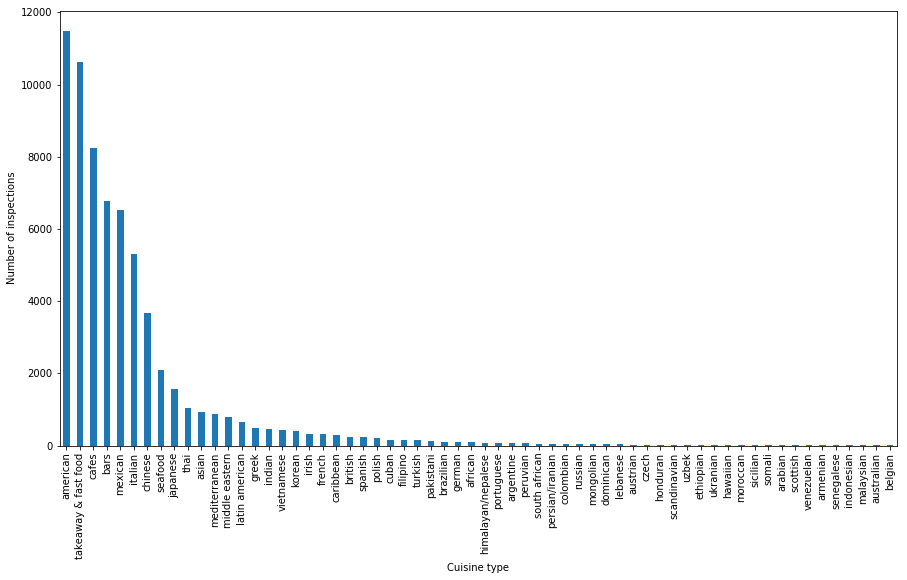

In [217]:
chicago_yelp['tags'] = chicago_yelp['tags'].str.split(',')
chicago_yelp_exploded = chicago_yelp.explode('tags')
chicago_yelp_exploded.tags.value_counts().plot(kind = 'bar', figsize = (15, 8))
plt.xlabel('Cuisine type')
plt.ylabel('Number of inspections')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.show()

In [218]:
cuisine_type_percentage = pd.DataFrame({'count': chicago_yelp_exploded['tags'].value_counts(), \
                                      'percentage':(chicago_yelp_exploded['tags'].value_counts()/chicago_yelp_exploded['tags'].count())*100})
print('>>>>>>>>>>>>>>The total number of cuisine type is %d<<<<<<<<<<<<<' % cuisine_type_percentage.shape[0])
cuisine_type_percentage.head()

>>>>>>>>>>>>>>The total number of cuisine type is 62<<<<<<<<<<<<<


count  percentage
american              11473   17.454474
takeaway & fast food  10635   16.179580
cafes                  8246   12.545070
bars                   6762   10.287383
mexican                6514    9.910088

In [219]:
valid_cuisine_types = cuisine_type_percentage[cuisine_type_percentage['count'] > 100].index.tolist()

In [220]:
valid_chicago_yelp = chicago_yelp_exploded.loc[chicago_yelp_exploded.tags.isin(valid_cuisine_types)]
valid_chicago_yelp.tags.nunique()

29

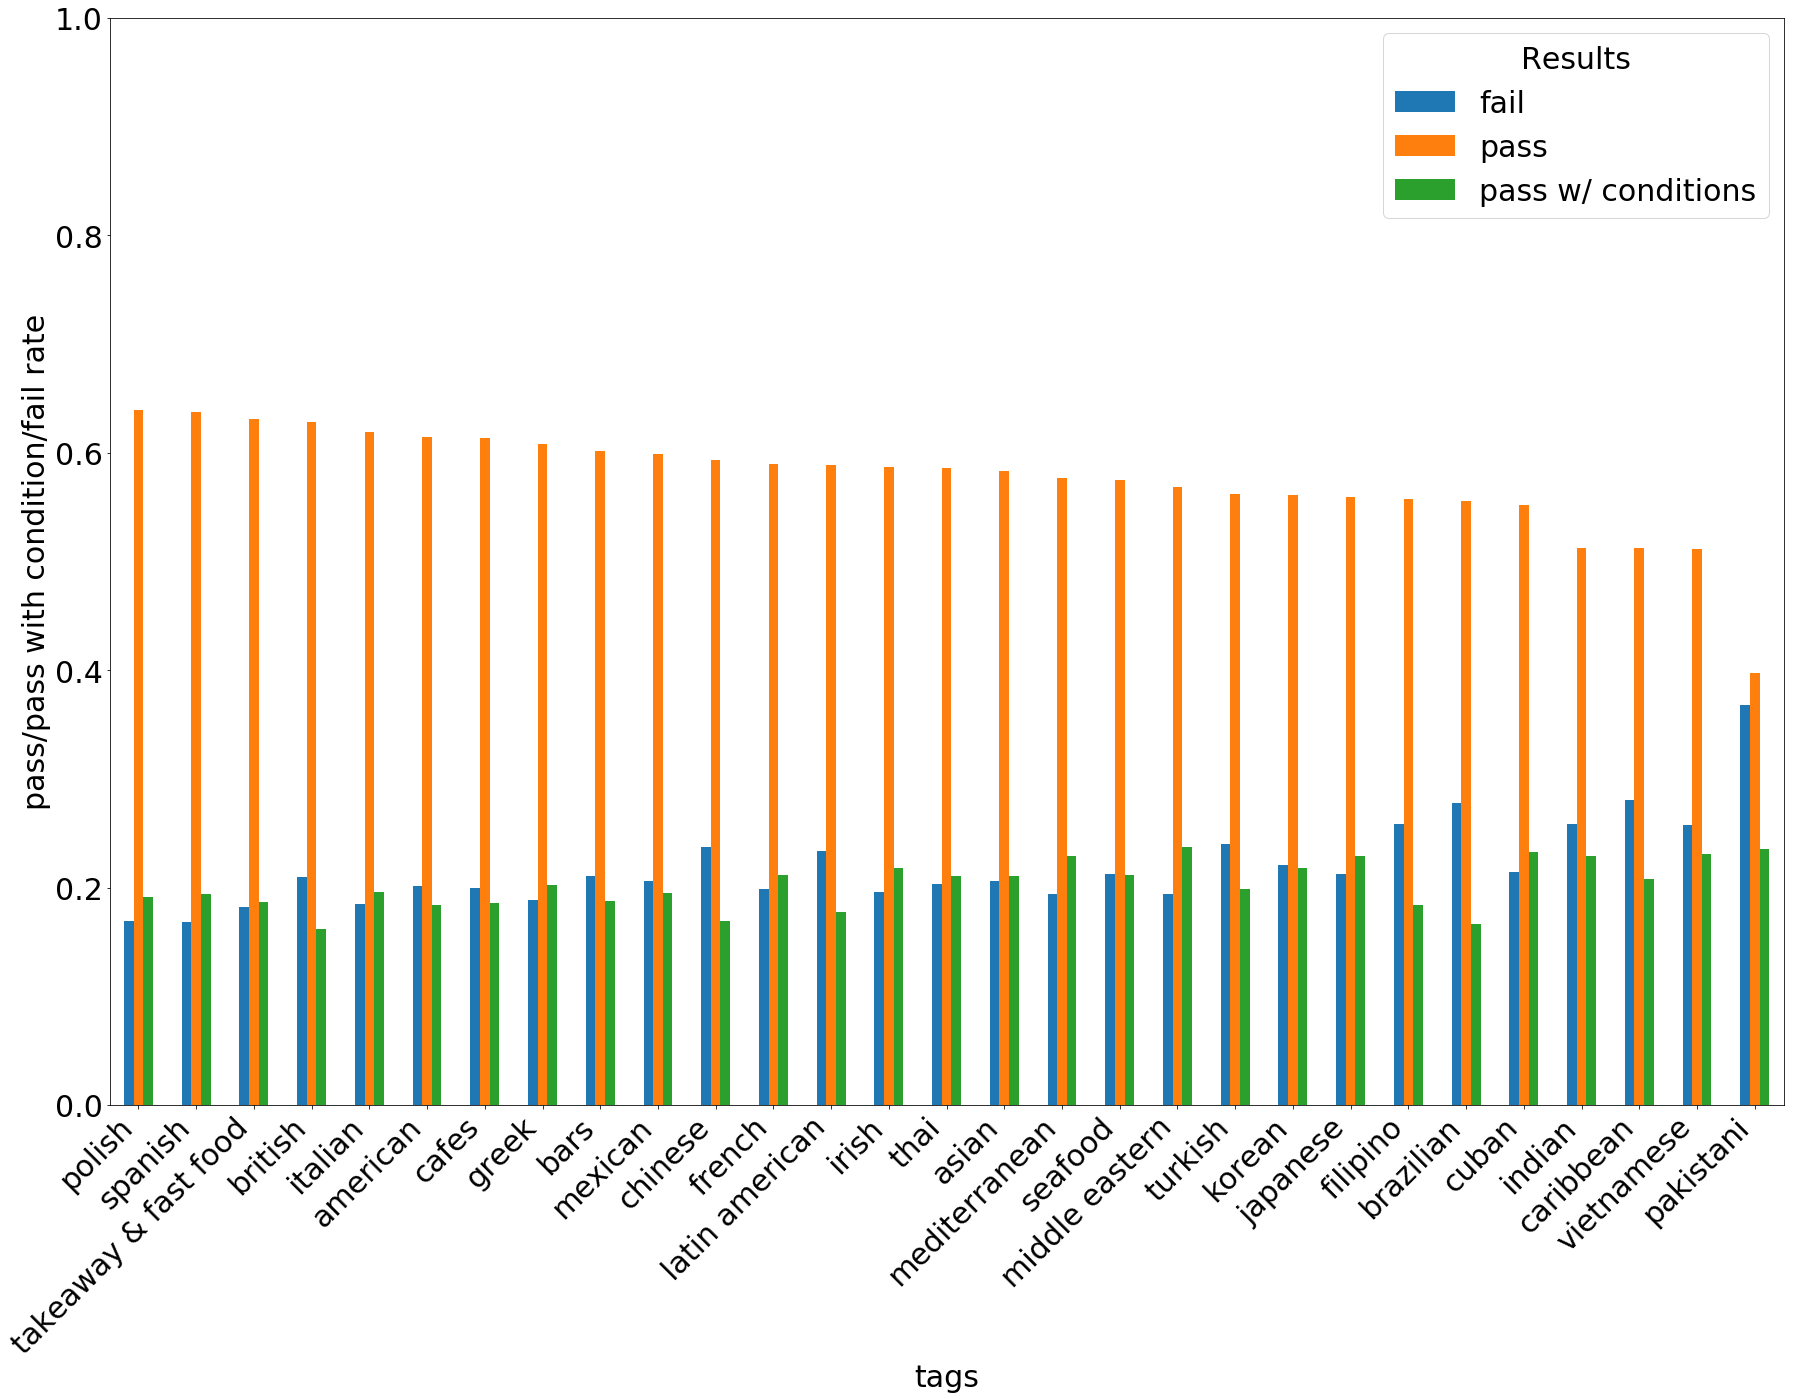

In [222]:
cuisine_type_rate = compute_rate(valid_chicago_yelp, 'tags')
cuisine_type_rate.sort_values(by = 'pass', ascending=False).plot(kind = 'bar', figsize=(30,20))
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('pass/pass with condition/fail rate')
plt.ylim([0,1])
plt.rc('font', size=30)          # controls default text sizes
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
plt.show()

**Observation**
According to the pass rate figure, we can rank these cuisines by their inspection results. 
We set a threshold of pass rate (60%), split Tier 1 and Tier 2. Tier 3 can then be distinguished as it performs prominently worse from others.

Tier 1: Polish, Spanish, British, Italian, American, Greek  
Tier 2: Mexican, Chinese, french, Latin-American, Irish, Thai, asian, Middle-eastern, Turkish, Korean, Japanese, Filipino, Brazilian, Cuban  
Tier 3: Indian, Vietnamese, Caribbean, Pakistani  

We observe that western cuisines cluster in Tier 1, while Tier 2 contains Latin-American and oriental dishes. Tier 3 includes Indian-Pakistani cuisines. Different cuisines may have different hygienic conditions due to the usage of particular ingredients, cooking methods, seasoning, etc. Therefore, it is possible that western cuisines make it easier to clean up and maintain hygiene than other cuisine types. 

## Price and Food Inspection Result

With the data from Yelp.com, we categorise restaurants in Chicago with respect to the average cost per person: 
1. low price ($1-$10) 
2. medium price ($11-$20)
3. high price ($21-$30)
4. very high price ($31+)

In [170]:
def change_price_label(x):
    if(x == '$'):
        return "\$"
    if(x == "$$"):
        return "\$\$"
    if(x == "$$$"):
        return "\$\$\$"
    if(x == "$$$$"):
        return "\$\$\$\$"
    else:
        return x
chicago_yelp.price_range = chicago_yelp.price_range.apply(lambda x: change_price_label(x))

In [171]:
chicago_yelp_price = chicago_yelp.loc[~chicago_yelp.price_range.isnull()]

In [180]:
price_rate = compute_rate(chicago_yelp_price, 'price_range')
price_rate

Results          fail      pass  pass w/ conditions
price_range                                        
\$           0.192374  0.625561            0.182065
\$\$         0.211489  0.590776            0.197735
\$\$\$       0.156566  0.652637            0.190797
\$\$\$\$     0.203636  0.596364            0.200000

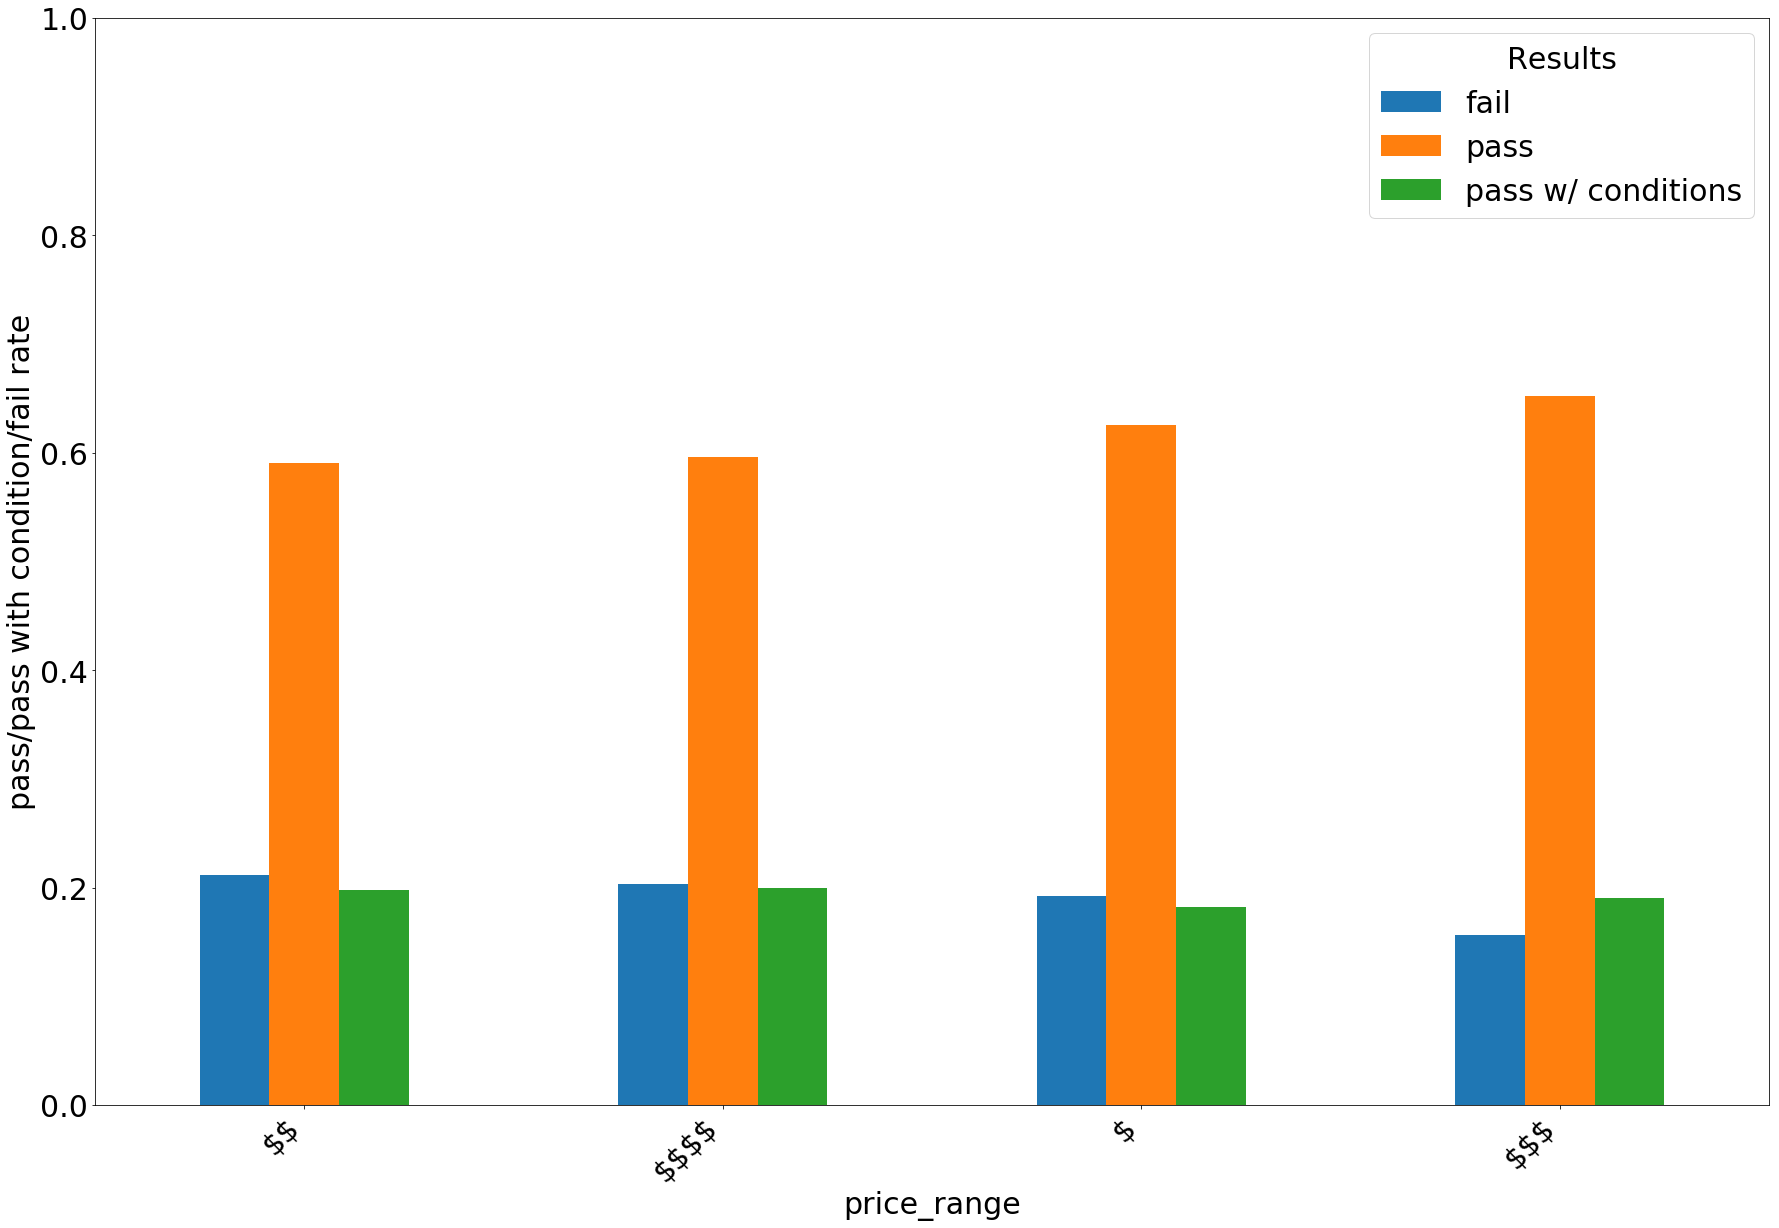

In [195]:
price_rate.sort_values(by = 'pass').plot(kind = 'bar', figsize=(30,20))
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=30)
plt.ylabel('pass/pass with condition/fail rate', fontsize=30)
plt.ylim([0,1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('pass/pass with condition/fail rate')
plt.ylim([0,1])
plt.show()

**Observation**  
As shown in the figure above, the gap between cleanness is not as large as the gap between their prices; actually, restaurants of different prices are of the same level of cleanness. For example, low-priced restaurants have an average pass rate of 62.5% and fail rate of 19.2%, while very-high-priced restaurants have an average pass rate of 59.6% and fail rate of 20.4%. There is no significant difference between them. 
Therefore, from the perspective of hygiene, restaurants of different prices are actually alike. There is no need to choose an expensive restaurant for a hygienic diet.

Deviating from typical common sense, it is shown that price and hygiene are not necessarily related. In fact, there are also other reports showing this phenomenon, for example, Fast Food Joints Are Cleaner than Fancy Restaurants and Way Cleaner than Your Kitchen (https://www.vice.com/en_us/article/9kd54v/fast-food-joints-are-cleaner-than-fancy-restaurants-and-way-cleaner-than-your-kitchen).

<a name="Yelp_data_cleaning"></a>